# **📳  MIT 15.071 Analytics Edge Final Project**

*Jiho Kil | Connor Redding |  Xinhui(Mary) Xu*

# **Table of Contents**

>**Outline**

>>**Data**

>**Data Preprocessing**

>>**Inspection of datasets**

>>**Merge datasets**

>>**Inspect 'Count' and 'Quarter' columns**

>>**Retain only one count and quarter column**

>>**Rename columns for readability**

>>**Check that every row refers to one unique customer**

>>**Missing values**

>>>**1. 'offer' field**

>>>**2. 'internet_type' field**

>>>**3. 'churn_category' and 'churn_reason' fields**

>**Exploratory Data Analysis**

>>**Data Dictionary**

>>**Descriptive Analysis**

>>**Address binary fields**

>>**Correlation**

>>>**Feature selection**

>>**Data Transformation for Modeling**

>>**Cluster Analysis**

>>>**Cluster Interpretation**

>**Predictive Modeling**

>>**Modeling Preparation**

>>>**Train-test Split**

>>>**Helper Functions**

>>**(Vanilla) Logistic Regression**

>>**Penalized Logistic Regression**

>>**CART**

>>**XGBoost**

>**Granular Churn Analysis**

>>**Scenario Description**

>>**Differentiated Losses**

>>**Expected Profit**

>>**(Vanilla) Logistic Regression**

>>**Penalized Logistic Regression**

>>**CART**

>>**XGBoost**

>>**Model Comparison**

>>**Expected Profit Comparison**

>**Modeling Conclusion**

>**Telco's Customer Retention Strategy**

>>>**Improve Satisfaction**

>>>**Incentivise Longer Term Contracts**

>>>**Better Access to Online Security Services**

>>>**Services For Senior Citizens**

>>>**Test for Viral Marketing Strategy**

>**Final Considerations**



# **Outline**

Customer churn is a phenomenon where customers discontinue their relationship with a company or service, and is a critical metric for understanding customer retention and business sustainability. Telco, a fictional company providing home phone and internet services in California, has provided a comprehensive dataset which includes customer demographics, account details, service information, and historical churn data. Their main objective is to devise an effective strategy for **customer retention** that takes into account the unique aspects of their customer data. By leveraging this data, we plan to enhance Telco's competitive edge through strategic, data-driven customer retention initiatives.


## **Data**

Our project utilizes a simulated dataset created by the [IBM Samples Team](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113). It assumes a home phone and internet services in California called Telco, and the data includes customer demographics, account information, service information and churn data.
Customer demographic information contains the customer's gender, age range, and if they have a partner or dependents.
Customer account information contains how long they’ve been a customer, contract type, payment method, paperless billing, monthly charges, and total charges.
Service information shows the type of services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV & movies.
Customer Churn information indicates whether or not they left within the last month.


In [ ]:
# Imports
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# Machine Learning
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

In [ ]:
# Run this block to load the Telco data for the session
import gdown

gdown.download_folder('https://drive.google.com/drive/folders/1XQBdN1kAuoGpJhHBMyngQniXp8w9xN0u?usp=share_link', use_cookies=False)

# **Data Preprocessing**

## **Inspection of datasets**

In [ ]:
# Replace with actual file paths
file_paths = [
  '/content/Data/Demographics.csv',
  '/content/Data/Location.csv',
  '/content/Data/Services.csv',
  '/content/Data/Status.csv',
]

# Dictionary to store our dataframes
dfs = {}

# Read each file and show basic information
for file_path in file_paths:
    print(f"\n=== Reading {file_path} ===")

    # Get the file name without extension to use as suffix
    file_suffix = '_' + file_path.split('.')[0]

    df = pd.read_csv(file_path, sep='\t', encoding='utf-16')

    # Rename all columns except 'Customer ID' to include the file source
    rename_dict = {
        col: f"{col}{file_suffix}"
        for col in df.columns
        if col != 'Customer ID'
    }
    df = df.rename(columns=rename_dict)

    dfs[file_path] = df

    print(f"Shape: {df.shape}")
    print(f"Columns: {', '.join(df.columns)}")
    print(f"Number of unique Customer IDs: {df['Customer ID'].nunique()}")

    # Display first few rows
    display(df.head())


=== Reading /content/Data/Demographics.csv ===
Shape: (7043, 9)
Columns: Customer ID, Count_/content/Data/Demographics, Gender_/content/Data/Demographics, Age_/content/Data/Demographics, Under 30_/content/Data/Demographics, Senior Citizen_/content/Data/Demographics, Married_/content/Data/Demographics, Dependents_/content/Data/Demographics, Number of Dependents_/content/Data/Demographics
Number of unique Customer IDs: 7043


,Customer ID,Count_/content/Data/Demographics,Gender_/content/Data/Demographics,Age_/content/Data/Demographics,Under 30_/content/Data/Demographics,Senior Citizen_/content/Data/Demographics,Married_/content/Data/Demographics,Dependents_/content/Data/Demographics,Number of Dependents_/content/Data/Demographics
0,1658-BYGOY,1,Male,71,No,Yes,No,Yes,3
1,3445-HXXGF,1,Male,66,No,Yes,Yes,No,0
2,4385-GZQXV,1,Female,68,No,Yes,No,No,0
3,0623-IIHUG,1,Female,77,No,Yes,No,No,0
4,9057-MSWCO,1,Male,71,No,Yes,Yes,No,0



=== Reading /content/Data/Location.csv ===
Shape: (7043, 10)
Columns: Location ID_/content/Data/Location, Customer ID, Count_/content/Data/Location, Country_/content/Data/Location, State_/content/Data/Location, City_/content/Data/Location, Zip Code_/content/Data/Location, Lat Long_/content/Data/Location, Latitude_/content/Data/Location, Longitude_/content/Data/Location
Number of unique Customer IDs: 7043


,Location ID_/content/Data/Location,Customer ID,Count_/content/Data/Location,Country_/content/Data/Location,State_/content/Data/Location,City_/content/Data/Location,Zip Code_/content/Data/Location,Lat Long_/content/Data/Location,Latitude_/content/Data/Location,Longitude_/content/Data/Location
0,VFGAGY6957,2656-FMOKZ,1,United States,California,Pasadena,91106,"34.139402, -118.128658",34.139402,-118.128658
1,LQYOZM6288,3488-PGMQJ,1,United States,California,Alpine,91901,"32.827184, -116.703729",32.827184,-116.703729
2,GUJJRB3775,7534-BFESC,1,United States,California,San Diego,92122,"32.85723, -117.209754",32.857230,-117.209774
3,FVSDWS6986,2840-XANRC,1,United States,California,San Diego,92122,"32.85723, -117.209760",32.857230,-117.209774
4,LVATLE5584,5564-NEMQO,1,United States,California,Thermal,92274,"33.53604, -116.119222",33.536040,-116.119222



=== Reading /content/Data/Services.csv ===
Shape: (7043, 31)
Columns: Service ID_/content/Data/Services, Customer ID, Count_/content/Data/Services, Quarter_/content/Data/Services, Referred a Friend_/content/Data/Services, Number of Referrals_/content/Data/Services, Tenure in Months_/content/Data/Services, Offer_/content/Data/Services, Phone Service_/content/Data/Services, Avg Monthly Long Distance Charges_/content/Data/Services, Multiple Lines_/content/Data/Services, Internet Service_/content/Data/Services, Internet Type_/content/Data/Services, Avg Monthly GB Download_/content/Data/Services, Online Security_/content/Data/Services, Online Backup_/content/Data/Services, Device Protection Plan_/content/Data/Services, Premium Tech Support_/content/Data/Services, Streaming TV_/content/Data/Services, Streaming Movies_/content/Data/Services, Streaming Music_/content/Data/Services, Unlimited Data_/content/Data/Services, Contract_/content/Data/Services, Paperless Billing_/content/Data/Services

,Service ID_/content/Data/Services,Customer ID,Count_/content/Data/Services,Quarter_/content/Data/Services,Referred a Friend_/content/Data/Services,Number of Referrals_/content/Data/Services,Tenure in Months_/content/Data/Services,Offer_/content/Data/Services,Phone Service_/content/Data/Services,Avg Monthly Long Distance Charges_/content/Data/Services,...,Unlimited Data_/content/Data/Services,Contract_/content/Data/Services,Paperless Billing_/content/Data/Services,Payment Method_/content/Data/Services,Monthly Charge_/content/Data/Services,Total Charges_/content/Data/Services,Total Refunds_/content/Data/Services,Total Extra Data Charges_/content/Data/Services,Total Long Distance Charges_/content/Data/Services,Total Revenue_/content/Data/Services
0,GEEYSJUHY6991,4846-WHAFZ,1,Q3,Yes,1,37,Offer C,Yes,6.33,...,Yes,Month-to-Month,Yes,Bank Withdrawal,76.50,2868.15,0.00,0,234.21,3102.36
1,CQIFHUNEW9871,2070-FNEXE,1,Q3,No,0,7,Offer E,Yes,26.95,...,No,Month-to-Month,No,Bank Withdrawal,76.45,503.60,11.05,0,188.65,681.20
2,YOBKZFGVQ5899,3606-TWKGI,1,Q3,No,0,13,Offer D,Yes,32.68,...,No,Month-to-Month,Yes,Bank Withdrawal,106.90,1364.30,0.00,10,424.84,1799.14
3,VHJDHJCGG5893,4385-GZQXV,1,Q3,No,0,16,Offer D,Yes,9.43,...,Yes,Month-to-Month,Yes,Bank Withdrawal,94.45,1511.20,0.00,0,150.88,1662.08
4,XNJUYZUTW5958,5020-ZSTTY,1,Q3,No,0,54,Offer B,Yes,12.08,...,Yes,One Year,No,Bank Withdrawal,82.45,4350.10,0.00,0,652.32,5002.42



=== Reading /content/Data/Status.csv ===
Shape: (7043, 15)
Columns: Status ID_/content/Data/Status, Customer ID, Count_/content/Data/Status, Quarter_/content/Data/Status, Satisfaction Score_/content/Data/Status, Satisfaction Score Label_/content/Data/Status, Customer Status_/content/Data/Status, Churn Label_/content/Data/Status, Churn Value_/content/Data/Status, Churn Score_/content/Data/Status, Churn Score Category_/content/Data/Status, CLTV_/content/Data/Status, CLTV Category_/content/Data/Status, Churn Category_/content/Data/Status, Churn Reason_/content/Data/Status
Number of unique Customer IDs: 7043


,Status ID_/content/Data/Status,Customer ID,Count_/content/Data/Status,Quarter_/content/Data/Status,Satisfaction Score_/content/Data/Status,Satisfaction Score Label_/content/Data/Status,Customer Status_/content/Data/Status,Churn Label_/content/Data/Status,Churn Value_/content/Data/Status,Churn Score_/content/Data/Status,Churn Score Category_/content/Data/Status,CLTV_/content/Data/Status,CLTV Category_/content/Data/Status,Churn Category_/content/Data/Status,Churn Reason_/content/Data/Status
0,VRZYZI9978,4598-XLKNJ,1,Q3,2,2,Churned,Yes,1,88,81-90,5337,5001-5500,Dissatisfaction,Limited range of services
1,YAMNBI7178,2656-FMOKZ,1,Q3,2,2,Churned,Yes,1,91,91-100,5717,5501-6000,Dissatisfaction,Limited range of services
2,OFKDMH9951,8098-LLAZX,1,Q3,3,3,Churned,Yes,1,85,81-90,3677,3501-4000,Competitor,Competitor made better offer
3,DHXVBL4276,5020-ZSTTY,1,Q3,1,1,Churned,Yes,1,83,81-90,4149,4001-4500,Competitor,Competitor made better offer
4,ZIEQWD5744,5804-LEPIM,1,Q3,3,3,Churned,Yes,1,73,71-80,2671,2501-3000,Other,Don't know


## **Merge datasets**

In [ ]:
# Merge all dataframes
print("\n=== Merging Dataframes ===")
customer_churn = dfs[file_paths[0]]
for file_path in file_paths[1:]:
    print(f"Merging with {file_path}...")
    customer_churn = pd.merge(customer_churn, dfs[file_path], on='Customer ID', how='outer')
    print(f"After merging: Shape = {customer_churn.shape}")

# Sort by Customer ID
customer_churn = customer_churn.sort_values('Customer ID')

# Display information about the merged dataset
print("\n=== Merged Dataset Information ===")
print(f"Total rows: {len(customer_churn)}")
print(f"Total columns: {len(customer_churn.columns)}")
print("\nColumns in merged dataset (grouped by source file):")
for file_path in file_paths:
    suffix = '_' + file_path.split('.')[0]
    cols = [col for col in customer_churn.columns if suffix in col]
    print(f"\n{file_path} columns:")
    for col in cols:
        print(f"- {col}")


# Display first few rows of the merged dataset
print("\n=== Preview of Merged Dataset ===")
display(customer_churn.head())

# Save the merged result
customer_churn.to_csv('merged_output.tsv', sep='\t', index=False, encoding='utf-16')
print("\nMerged file has been saved as 'merged_output.tsv'")

# Additional analysis of Customer ID distribution
print("\n=== Customer ID Analysis ===")
for file_path in file_paths:
    df = dfs[file_path]
    total_ids = df['Customer ID'].nunique()
    shared_ids = df['Customer ID'].isin(customer_churn['Customer ID']).sum()
    print(f"{file_path}:")
    print(f"- Unique Customer IDs: {total_ids}")
    print(f"- IDs present in final merge: {shared_ids}")


=== Merging Dataframes ===
Merging with /content/Data/Location.csv...
After merging: Shape = (7043, 18)
Merging with /content/Data/Services.csv...
After merging: Shape = (7043, 48)
Merging with /content/Data/Status.csv...
After merging: Shape = (7043, 62)

=== Merged Dataset Information ===
Total rows: 7043
Total columns: 62

Columns in merged dataset (grouped by source file):

/content/Data/Demographics.csv columns:
- Count_/content/Data/Demographics
- Gender_/content/Data/Demographics
- Age_/content/Data/Demographics
- Under 30_/content/Data/Demographics
- Senior Citizen_/content/Data/Demographics
- Married_/content/Data/Demographics
- Dependents_/content/Data/Demographics
- Number of Dependents_/content/Data/Demographics

/content/Data/Location.csv columns:
- Location ID_/content/Data/Location
- Count_/content/Data/Location
- Country_/content/Data/Location
- State_/content/Data/Location
- City_/content/Data/Location
- Zip Code_/content/Data/Location
- Lat Long_/content/Data/Locatio

,Customer ID,Count_/content/Data/Demographics,Gender_/content/Data/Demographics,Age_/content/Data/Demographics,Under 30_/content/Data/Demographics,Senior Citizen_/content/Data/Demographics,Married_/content/Data/Demographics,Dependents_/content/Data/Demographics,Number of Dependents_/content/Data/Demographics,Location ID_/content/Data/Location,...,Satisfaction Score Label_/content/Data/Status,Customer Status_/content/Data/Status,Churn Label_/content/Data/Status,Churn Value_/content/Data/Status,Churn Score_/content/Data/Status,Churn Score Category_/content/Data/Status,CLTV_/content/Data/Status,CLTV Category_/content/Data/Status,Churn Category_/content/Data/Status,Churn Reason_/content/Data/Status
0,0002-ORFBO,1,Female,37,No,No,Yes,No,0,FUGQUJ6597,...,3,Stayed,No,0,65,61-70,2205,2000-2500,NaN,NaN
1,0003-MKNFE,1,Male,46,No,No,No,No,0,SIZFEJ5344,...,5,Stayed,No,0,66,61-70,5414,5001-5500,NaN,NaN
2,0004-TLHLJ,1,Male,50,No,No,No,No,0,RZDAXJ8786,...,1,Churned,Yes,1,71,71-80,4479,4001-4500,Competitor,Competitor had better devices
3,0011-IGKFF,1,Male,78,No,Yes,Yes,No,0,MGKGVM9555,...,1,Churned,Yes,1,91,91-100,3714,3501-4000,Dissatisfaction,Product dissatisfaction
4,0013-EXCHZ,1,Female,75,No,Yes,Yes,No,0,FJLSME1564,...,1,Churned,Yes,1,68,61-70,3464,3001-3500,Dissatisfaction,Network reliability



Merged file has been saved as 'merged_output.tsv'

=== Customer ID Analysis ===
/content/Data/Demographics.csv:
- Unique Customer IDs: 7043
- IDs present in final merge: 7043
/content/Data/Location.csv:
- Unique Customer IDs: 7043
- IDs present in final merge: 7043
/content/Data/Services.csv:
- Unique Customer IDs: 7043
- IDs present in final merge: 7043
/content/Data/Status.csv:
- Unique Customer IDs: 7043
- IDs present in final merge: 7043

=== Column Name Reference ===
Here's a reference for the renamed columns:

/content/Data/Demographics.csv columns:

/content/Data/Location.csv columns:

/content/Data/Services.csv columns:

/content/Data/Status.csv columns:


## **Inspect 'Count' and 'Quarter' columns**

We checked and confirmed that all 'Count' and 'Quarter' columns are identical and thus would be redundant if all of them remained for analyses.

In [ ]:
# Get columns starting with "Count"
count_columns = [col for col in customer_churn.columns if col.startswith("Count_")]

# Extract DataFrame with only the "Count_" columns:
count_df = customer_churn[count_columns]

# Assert if all the columns are equal
# By checking whether every row has only one unique value (which is 1)
np.all(count_df.nunique(axis=1) == 1)

True

In [ ]:
# Get columns starting with "Quarter"
quarter = [col for col in customer_churn.columns if col.startswith("Quarter")]

# Extract DataFrame with only the "Quarter_" columns:
quarter_df = customer_churn[quarter]

# Assert if all the columns are equal
# By checking whether every row has only one unique value (which is 1)
np.all(quarter_df.nunique(axis=1) == 1)

True

## **Retain only one count and quarter column**

Since all the columns of 'Count' and 'Quarter' were equal, we decided to retain only one of those columns to reduce reduncancy.

In [ ]:
quarter_df.columns

Index(['Quarter_/content/Data/Services', 'Quarter_/content/Data/Status'], dtype='object')

In [ ]:
# Drop all columns except the first
columns_to_drop = list(count_df.columns[1:]) + list(quarter_df.columns[1:])
customer_churn = customer_churn.drop(columns=columns_to_drop)

## **Rename columns for readability**

We had previously retained the filepath of each column as the column name in order to distinguish the feature's source dataset during the inspection and merging process. Now that we joined all four datasets into one, we decided to rename each column for interpretability.

In [ ]:
def clean_column_names(df):
    # Create a dictionary to store the old and new column names
    new_names = {}
    for col in df.columns:
        # If there's an underscore in the column name
        if '_' in col:
            # Take the part before the first underscore
            new_name = col.split('_')[0]
        else:
            # If no underscore, take the whole column name
            new_name = col
        # Convert to lowercase
        new_name = new_name.lower()
        # Replace spaces with underscore
        new_name = new_name.replace(' ', '_')
        # Add to dictionary
        new_names[col] = new_name
    # Rename the columns using the dictionary
    df = df.rename(columns=new_names)
    return df

# Apply function
customer_churn = clean_column_names(customer_churn)

## **Check that every row refers to one unique customer**

We did this to ensure that our analysis would not be hidered by duplicates that may have resulted from joining the datasets.

In [ ]:
np.all(customer_churn['customer_id'].value_counts() == 1)

True

## **Missing values**

In our dataset, **4 fields** contained missing values:
**offer, internet_type, churn_category,** and **churn_reason**.

In this section we address each field and its corresponding missingness.

In [ ]:
# Check for missing values
print("\n=== Missing Values Analysis ===")
missing_values = customer_churn.isnull().sum()
missing_pct = (customer_churn.isnull().sum() / len(customer_churn)) * 100

missing_analysis = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing': missing_pct
})
display(missing_analysis[missing_analysis['Missing Values'] > 0])


=== Missing Values Analysis ===


,Missing Values,Percentage Missing
offer,3877,55.047565
internet_type,1526,21.666903
churn_category,5174,73.463013
churn_reason,5174,73.463013


### **1. *offer* field**

In [ ]:
# Unique values of 'offer'
customer_churn['offer'].value_counts()

,count
offer,
Offer B,824
Offer E,805
Offer D,602
Offer A,520
Offer C,415


According to the data dictionary (shown below in the '**Data Dictionary**' section), The *offer* column indicates the last marketing offer that the customer accepted among the five categories (A~E). Therefore, we assumed that missing values imply that the customer did not accept any offers in Q3 (which is the only quarter existing for this dataset) among the five categories. Therefore, we replaced the missing values with the string 'No Offer'.

In [ ]:
# Replace missing values with 'No Offer'
customer_churn['offer'] = customer_churn['offer'].fillna('No Offer')

In [ ]:
# Check for successful imputation
customer_churn['offer'].value_counts()

,count
offer,
No Offer,3877
Offer B,824
Offer E,805
Offer D,602
Offer A,520
Offer C,415


### **2. *internet_type* field**

According to the data dictionary (shown below), The 'internet_type' column indicates if the customer subscribed to an internet service with the company, showing the internet type if true. Similar to the 'offer' column, missing values imply that the customer did not subscribe to an internet service. In fact, we confirmed this by checking that the *internet_service* feature, a binary column indicating whether the customer has subscribed to an internet service, showed 'No' when the 'internet_type' showed missingness. Therefore, we replaced the missing values with the string 'No Service'.

In [ ]:
# Unique values of 'internet_type'
customer_churn['internet_type'].value_counts()

,count
internet_type,
Fiber Optic,3035
DSL,1652
Cable,830


In [ ]:
# Check the NA segment of 'internet type'
service_na = customer_churn[['internet_type', 'internet_service']][customer_churn['internet_type'].isna()]
service_na.head()

,internet_type,internet_service
20,NaN,No
23,NaN,No
24,NaN,No
27,NaN,No
28,NaN,No


In [ ]:
# Count customers with 'No' internet service
no_internet = len(customer_churn[customer_churn['internet_service'] == 'No'])

# Get the count of missing values in internet_type
missing_internet_type = missing_values['internet_type']

# Count customers with both missing internet_type and 'No' internet service
missing_and_no = len(customer_churn[['internet_type', 'internet_service']]
                    [(customer_churn['internet_type'].isna()) &
                     (customer_churn['internet_service'] == 'No')])

# Check if all three counts are equal
print(no_internet == missing_internet_type == missing_and_no)

True


In [ ]:
# Replace missing values with 'No Service'
customer_churn['internet_type'] = customer_churn['internet_type'].fillna('No Service')

In [ ]:
# Check for successful imputation
customer_churn['internet_type'].value_counts()

,count
internet_type,
Fiber Optic,3035
DSL,1652
No Service,1526
Cable,830


### **3. *churn_category* and *churn_reason* fields**

The *churn_category* and *churn_reason* are directly related.
In Telco, when customers leave the service, all customers are asked about their reasons for leaving via a survey.

The *churn_category* is divided into five categories: **Attitude**, **Competitor**, **Dissatisfaction**, **Price**, and **Other**.
The *churn_reason* is a more granular reason for leaving the company that forms a **hierarchical relationship** with *churn_category*.

For the *churn_category*, there is already a category called 'Other' which indates a reason apart from the four categories. And 'Other' is divided to four specific churn reasons in the hierarchy: ['Don't know', 'Moved', 'Poor expertise of online support', 'Deceased'].

Therefore, assuming that the missingness resulted from the customers not answering the survey questions, we
replaced the missingness in *churn_category* with 'Other' and the missingness in *churn_reason* with 'Don't know' to retain the hierarchical relationship.

It is important to remember that the data includes both people who churned and people who stayed. Therefore, using the 'churn_value' as an indicator, we imputed the missing places that correspond to a churn_value of 0 with 'No Churn'.

After imputation we observed that all of the missing data actually belonged to the 'No Churn' value, which makes sense since customers who did not churn wouldn't be answering these survey questions.

In [ ]:
# Impute churn_category and churn_reason

# For churn_category
customer_churn.loc[(customer_churn['churn_value'] == 1) & (customer_churn['churn_category'].isna()), 'churn_category'] = 'Other'
customer_churn.loc[(customer_churn['churn_value'] == 0) & (customer_churn['churn_category'].isna()), 'churn_category'] = 'No Churn'

# For churn_reason
customer_churn.loc[(customer_churn['churn_value'] == 1) & (customer_churn['churn_reason'].isna()), 'churn_reason'] = "Don't know"
customer_churn.loc[(customer_churn['churn_value'] == 0) & (customer_churn['churn_reason'].isna()), 'churn_reason'] = 'No Churn'

In [ ]:
# Check for successful imputation of 'churn_category'
customer_churn['churn_category'].value_counts()

,count
churn_category,
No Churn,5174
Competitor,841
Attitude,314
Dissatisfaction,303
Price,211
Other,200


In [ ]:
# Check for successful imputation of 'churn_reason'
customer_churn['churn_reason'].value_counts()

,count
churn_reason,
No Churn,5174
Competitor had better devices,313
Competitor made better offer,311
Attitude of support person,220
Don't know,130
Competitor offered more data,117
Competitor offered higher download speeds,100
Attitude of service provider,94
Price too high,78


### **Final Missingness Check**

In [ ]:
# Check that there is no missingness in the data anymore
customer_churn.isnull().sum().sum() == 0

True

# **Exploratory Data Analysis**

## **Data Dictionary**

The follwing is our data dictionary, providing information about each field. The dataset pertains to information on customers from a hypothetical telecomuniations company called Telco, providing service subscription/churn records of unique customers in California, USA at the 3rd quarter. There were five datasets originally which we merged into one (we did not use the Population dataset for this project however), so we divided the data dictionary into five parts according to the specific dataset the features had belonged to.

Please refer to [IBM's webpage on Telco data](https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113) for further details about the data.


**--Demographics Data--**

CustomerID: A unique ID that identifies each customer.

Count: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.

Gender: The customer’s gender: Male, Female

Age: The customer’s current age, in years, at the time the fiscal quarter ended.

Senior Citizen: Indicates if the customer is 65 or older: Yes, No

Married: Indicates if the customer is married: Yes, No

Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.
Number of Dependents: Indicates the number of dependents that live with the customer.

**--Location Data--**

Country: The country of the customer’s primary residence.

State: The state of the customer’s primary residence.

City: The city of the customer’s primary residence.

Zip Code: The zip code of the customer’s primary residence.

Lat Long: The combined latitude and longitude of the customer’s primary residence.

Latitude: The latitude of the customer’s primary residence.

Longitude: The longitude of the customer’s primary residence.

**--Population Data--**

Zip Code: The zip code of the customer’s primary residence.

Population: A current population estimate for the entire Zip Code area.


**--Service Data--**

Quarter: The fiscal quarter that the data has been derived from (only contains Q3 for this data).

Referred a Friend: Indicates if the customer has ever referred a friend or family member to this company: Yes, No

Number of Referrals: Indicates the number of referrals to date that the customer has made.

Tenure in Months: Indicates the total amount of months that the customer has been with the company by the end of the 3rd quarter.

Offer: Identifies the last marketing offer that the customer accepted, if applicable. Values include No Offer, Offer A, Offer B, Offer C, Offer D, and Offer E.

Phone Service: Indicates if the customer subscribes to home phone service with the company. Yes, No

Avg Monthly Long Distance Charges: Indicates the customer’s average long distance charges, calculated to the end of the quarter specified above.

Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

Internet Type: Indicates if the customer subscribes to Internet service with the company: No Subscription, DSL, Fiber Optic, Cable.

Avg Monthly GB Download: Indicates the customer’s average download volume in gigabytes, calculated to the end of the quarter specified above.

Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

Device Protection Plan: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

Premium Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

Streaming Music: Indicates if the customer uses their Internet service to stream music from a third party provider: Yes, No. The company does not charge an additional fee for this service.

Unlimited Data: Indicates if the customer has paid an additional monthly fee to have unlimited data downloads/uploads: Yes, No
Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No

Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.

Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

Total Revenue: Indicates total revenue of the company. No further details in IBM's data dictionary.

Total Refunds: Indicates the customer’s total refunds, calculated to the end of the quarter specified above.

Total Extra Data Charges: Indicates the customer’s total charges for extra data downloads above those specified in their plan, by the end of the quarter specified above.

Total Long Distance Charges: Indicates the customer’s total charges for long distance above those specified in their plan, by the end of the 'quarter' field.


**--Status Data--**

Quarter: The fiscal quarter that the data has been derived from (e.g. Q3).

Satisfaction Score: A customer’s overall satisfaction rating of the company from 1 (Very Unsatisfied) to 5 (Very Satisfied).

Satisfaction Score Label: Indicates the text version of the score (1-5) as a text string.

Customer Status: Indicates the status of the customer at the end of the quarter: Churned, Stayed, or Joined

Churn Label: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

Churn Value: 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

Churn Score: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.

Churn Score Category: A calculation that assigns a Churn Score to one of the following categories: 0-10, 11-20, 21-30, 31-40, 41-50, 51-60, 61-70, 71-80, 81-90, and 91-100

CLTV: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

CLTV Category: A calculation that assigns a CLTV value to one of the following categories: 2000-2500, 2501-3000, 3001-3500, 3501-4000, 4001-4500, 4501-5000, 5001-5500, 5501-6000, 6001-6500, and 6501-7000.

Churn Category: A high-level category for the customer’s reason for churning: Attitude, Competitor, Dissatisfaction, Other, Price. When they leave the company, all customers are asked about their reasons for leaving. Directly related to Churn Reason.

Churn Reason: A customer’s specific reason for leaving the company. Directly related to Churn Category.


## **Descriptive Analysis**


In the descriptive analysis, we explored the means of each column, gender composition by churn,
age distribution by churn, satisfaction score by churn, count by reason with
satisfaction score label, and count by churn category with satisfaction score label.

Following are the main insights generated from the analysis:


**•** No clear patterns discovered in turns of churn status by gender.

**•** The churn rate is noticeably higher in **senior population** than in younger
population.

**•** 3 is the threshold for churn in terms of satisfaction rate.

**•** The main reason for customer churn is competitors. Customers who churned have noted
that competitors provided better devices, made more attractive deals, and
offered more data.

**•** The attitude of Telco's support personnel was also a key factor contributing to
customer churn.

Mean Values:
count                                    1.000000
age                                     46.509726
number_of_dependents                     0.468692
zip_code                             93486.071134
latitude                                36.197455
longitude                             -119.756684
number_of_referrals                      1.951867
tenure_in_months                        32.386767
avg_monthly_long_distance_charges       22.958954
avg_monthly_gb_download                 20.515405
monthly_charge                          64.761692
total_charges                         2280.381264
total_refunds                            1.962182
total_extra_data_charges                 6.860713
total_long_distance_charges            749.099262
total_revenue                         3034.379056
satisfaction_score                       3.244924
satisfaction_score_label                 3.244924
churn_value                              0.265370
churn_score                          

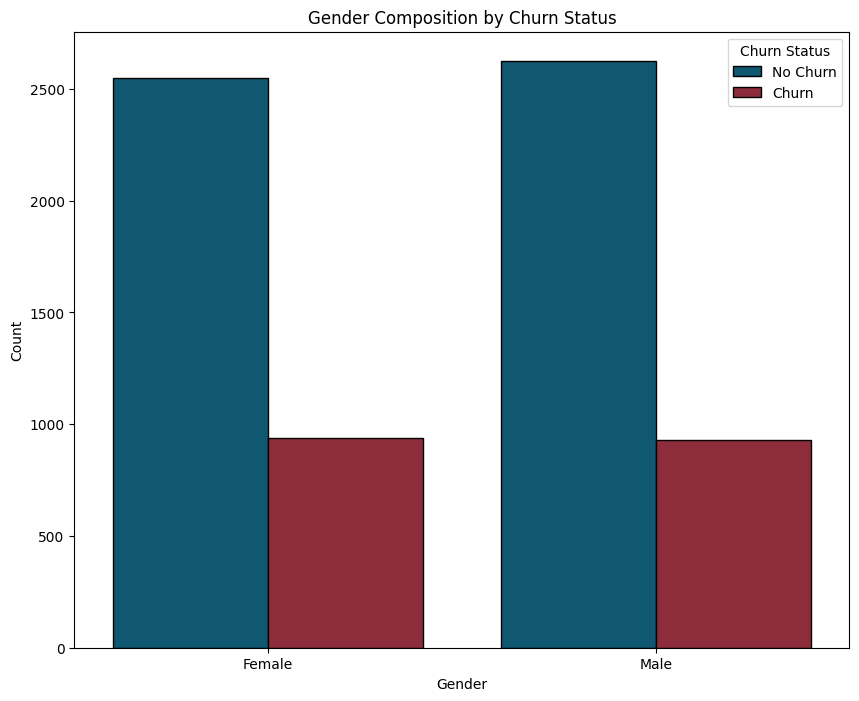

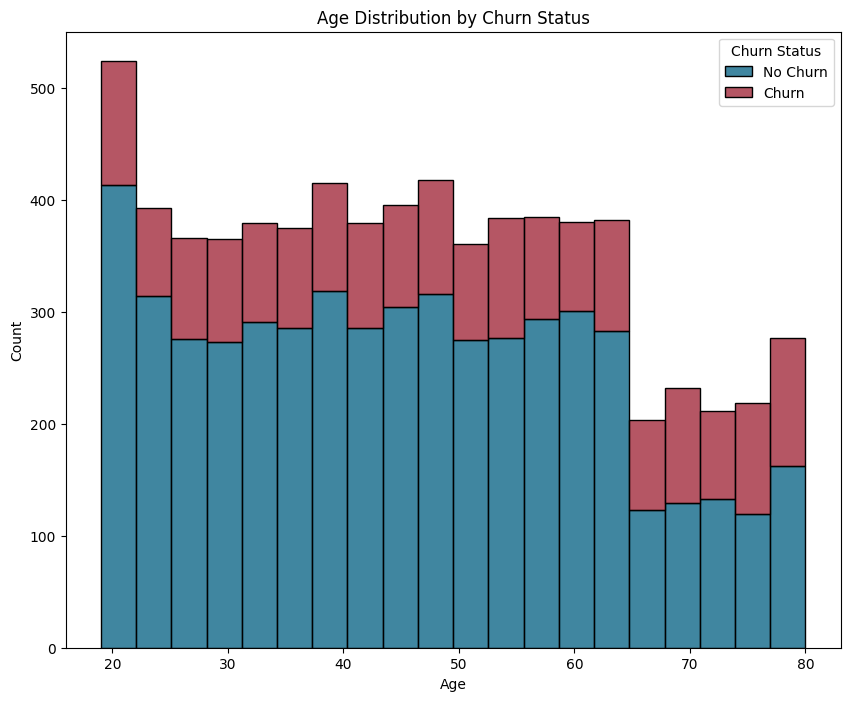

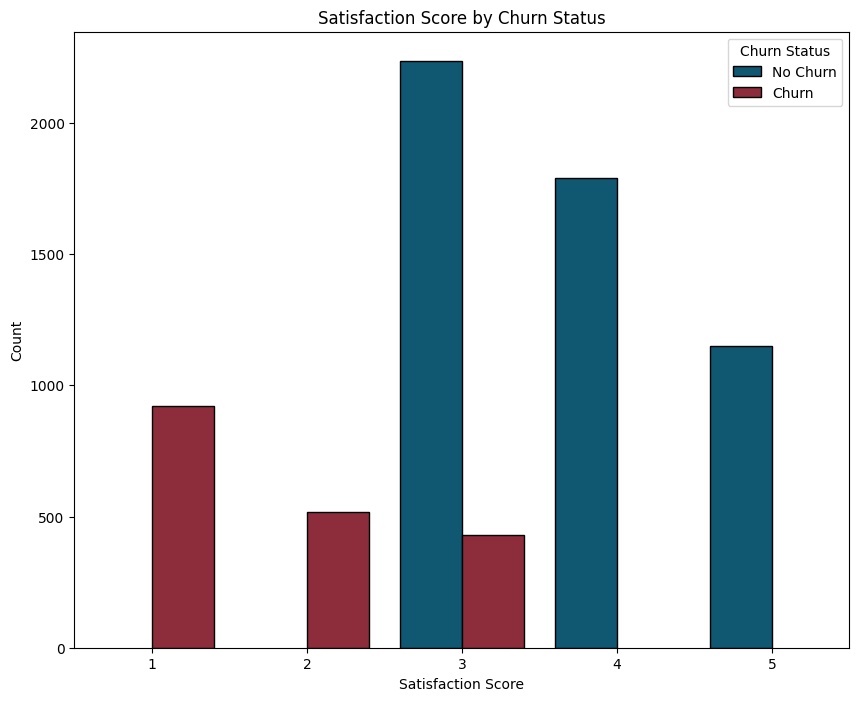

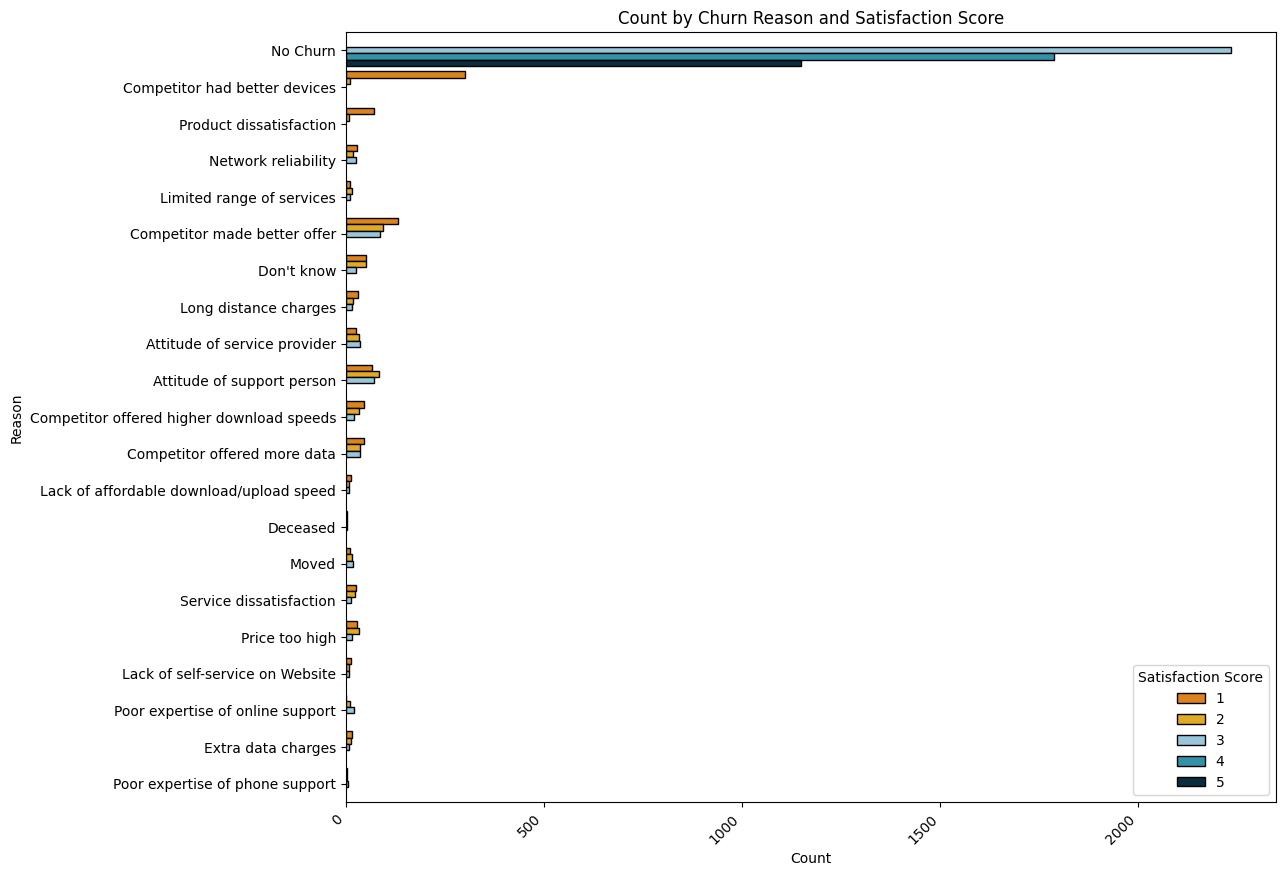

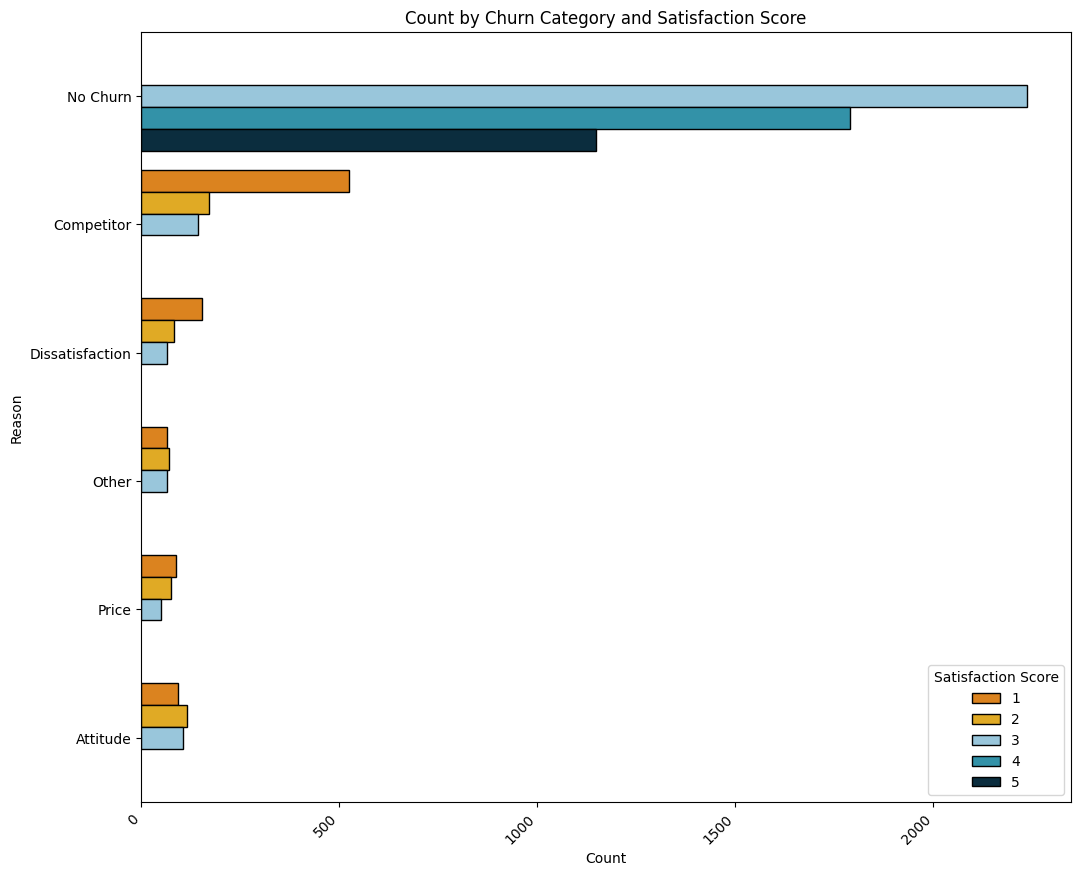

In [ ]:
#Means of each column
numeric_columns = customer_churn.select_dtypes(include=['int64', 'float64'])
mean_values = numeric_columns.mean()
print("Mean Values:")
print(mean_values)

#Demographics Analysis
#Gender composition by churn
plt.figure(figsize=(10, 8))
sns.countplot(data=customer_churn, x='gender', hue='churn_value',
              palette={1: '#9D1D30', 0: '#005E81'},edgecolor='black',
              hue_order=[0, 1])
plt.title('Gender Composition by Churn Status')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['No Churn', 'Churn'], loc='upper right')
plt.show()

#Age distribution by churn
plt.figure(figsize=(10, 8))
sns.histplot(data = customer_churn, x='age', hue ='churn_value', bins=20,
             palette={1: '#9D1D30', 0: '#005E81'}, multiple='stack', edgecolor='black',
             hue_order=[1, 0])
plt.title('Age Distribution by Churn Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.legend(title='Churn Status',labels=['No Churn', 'Churn'], loc='upper right')
plt.show()

#Satisfaction Rate by churn
plt.figure(figsize=(10, 8))
sns.countplot(data = customer_churn, x='satisfaction_score', hue ='churn_value',
              palette={1: '#9D1D30', 0: '#005E81'}, edgecolor='black',
              hue_order=[0, 1])
plt.title('Satisfaction Score by Churn Status')
plt.xlabel('Satisfaction Score')
plt.ylabel('Count')
plt.legend(title='Churn Status', labels=['No Churn', 'Churn'], loc='upper right')
plt.show()

#Count by reason and Satisfaction Score label
plt.figure(figsize=(12, 10))
sns.countplot(customer_churn, y='churn_reason', hue='satisfaction_score',
              palette={1:'#FA8500', 2:'#FFB706', 3:'#8ECAE6', 4:'#1F9EBC', 5:'#023047'},
              width=0.85, dodge=True, edgecolor='black')
plt.title('Count by Churn Reason and Satisfaction Score')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Count')
plt.ylabel('Reason')
plt.legend(title='Satisfaction Score', loc='lower right')
plt.show()

#Count by reason and Satisfaction Score label
plt.figure(figsize=(12, 10))
sns.countplot(customer_churn, y='churn_category', hue='satisfaction_score',
              palette={1:'#FA8500', 2:'#FFB706', 3:'#8ECAE6', 4:'#1F9EBC', 5:'#023047'},
              width=0.85, dodge=True, edgecolor='black')
plt.title('Count by Churn Category and Satisfaction Score')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Count')
plt.ylabel('Reason')
plt.legend(title='Satisfaction Score', loc='lower right')
plt.show()

## **Address binary fields**

There were many binary fields in our dataset that needed to be addressed before implementing algorithmic methods for analyses. We converted the binary categories into appropriate numerical representations suitable for algorithmic operations.

In [ ]:
# Turn gender into binary value
customer_churn['gender'] = customer_churn['gender'].apply(lambda x: 1 if x == 'Male' else 0)

# Turn every Yes and No into binary value
customer_churn = customer_churn.replace(['Yes', 'No'], [1, 0])

# Check for successful conversion
customer_churn['churn_label'].head()

<ipython-input-26-396bed30eb96>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  customer_churn = customer_churn.replace(['Yes', 'No'], [1, 0])


,churn_label
0,0
1,0
2,1
3,1
4,1


## **Correlation**

The correlation heatmap showed that there are some features which are highly correlated. We investigated these variables prior to using algorithmic methods to avoid potential issues surrounding multicollinearity and information redundancy in terms of interpretation.

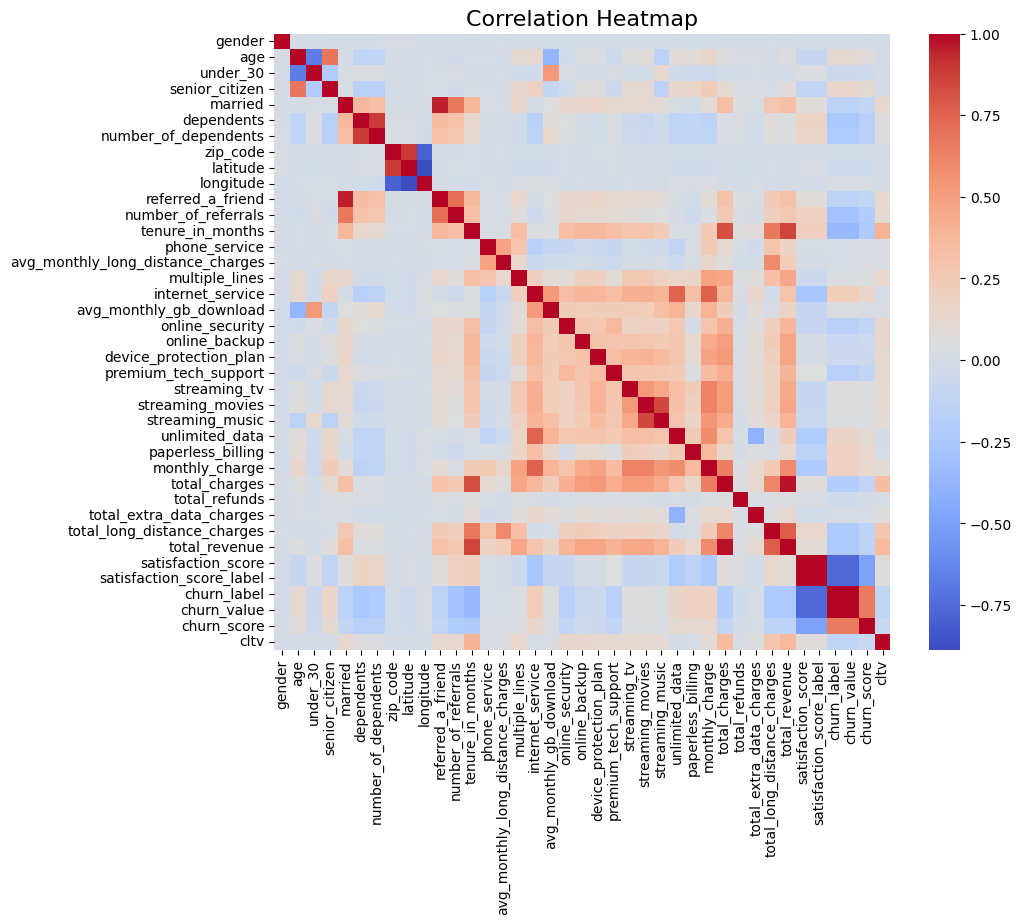

In [ ]:
# Get only numeric fields except the count column
customer_churn_numeric = customer_churn.select_dtypes(include=[np.number]).drop('count', axis=1)

# Calculate the correlation matrix
correlation_matrix = customer_churn_numeric.corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    cmap="coolwarm",
    cbar=True,
    square=True
)

plt.title("Correlation Heatmap", fontsize=16)
plt.show()

### **Feature selection**

**-- 'referred_a_friend' vs 'married'**

The two variables in our dataset are highly corelated with a coefficient of 0.95. Coupled with the fact that both are binary indicators, this implies they are essentially predictive of each other. Furthermore, one is a behavioral metric while the other is a demographic status, making it difficult to combine the variables.

Therefore, in our analysis, we decided to focus exclusively on ***referred_a_friend***, as it is a behavioral metric that the company can leverage for future business decisions, offering significantly higher strategic value compared to *married*, which represents a demographic factor beyond the company’s influence.


**--'toal_charges' vs 'total_revenue'**

These two are also highly correlated with a coefficient of 0.97. Considering our objective of customer behavior analysis and a clear explanation of the *total_charges* field compared to the *total_revenue*, we chose to focus exclusively on *total_charges* in our modeling.


**-- 'monthly_charge' & 'tenure_in_months' vs 'total_charges'**

There is almost a perfectly collinear relationship between the product of *monthly_charge* and *tenure_in_months* vs. *total_charges*. The monthly_charge * tenure is not exactly equal to total_charge, but very similar (correlation of 0.99).   It is likely because *monthly_charge* is the 'current' monthy charge while the *total_charge* would have taken into account the slightly different monthly charges. Therefore, we decided to remove *total_charges* from our analysis considering that *total_charges* is a derivative of the other two variables and that *monthly_charges* and *tenure_in_months* provides more actionable insights into customer behavior.

**-- 'dependents' vs 'number_of_dependents'**

These two are also highly correlated. We decided to choose to keep *number_of_dependents*, as it provides more granular information which also encompasses the existence of dependents provided by the binary variable *dependents*.

**-- 'satisfaction_score' vs 'satisfaction_score_label'**

These two are identical fields, so we chose to remove the *satisfaction_score_label* and use the *satisfaction_score*.

**-- 'churn_label' vs 'churn_value'**

These two are also identical fields, so we decided to remove the *churn_label* and use '*churn_value*.

In [ ]:
# These are highly correlated
corr_referr_married = customer_churn_numeric['referred_a_friend'].corr(customer_churn_numeric['married'])
print(f'referred_a_friend vs married: {corr_referr_married}')

corr_referr_married = customer_churn_numeric['total_charges'].corr(customer_churn_numeric['total_revenue'])
print(f'total_charges vs total_revenue: {corr_referr_married}')

estimate_total_charge = customer_churn_numeric['monthly_charge'] * customer_churn_numeric['tenure_in_months']
corr_estimate_total_charge = estimate_total_charge.corr(customer_churn_numeric['total_charges'])
print(f'estimate of total_charge vs actual total_charge: {corr_estimate_total_charge}')

dependents = customer_churn_numeric['dependents'].corr(customer_churn_numeric['number_of_dependents'])
print(f'dependents vs number_of_dependents : {dependents}')


referred_a_friend vs married: 0.9499865007311666
total_charges vs total_revenue: 0.972212108028603
estimate of total_charge vs actual total_charge: 0.9995603311375845
dependents vs number_of_dependents : 0.8882337266474477


In [ ]:
# Drop correlated columns
customer_churn = customer_churn.drop(['married', 'total_revenue', 'total_charges', 'dependents', 'satisfaction_score_label', 'churn_label'], axis=1)

## **Data Transformation for Modeling**

We separated variables by type to used them for our modeling process. We retained binary variables, while we implemented one hot encoding on the categorical fields.

We omitted fields that would be less relevant to the analysis, such as 'customer_id', 'location_id' and 'count'. We further excluded the 'country' and 'state' variables since they only contained one value (US, California respectively).

We also omitted the 'city' variable which contained more than 1000 unique cities. This is because implementing one-hot-encoding on this variable would introduce too much dimensionality and sparcity (which can lead the models to overfit and cause issues in K-means distance-based clustering methods), and the telecommunication services can be considered to be standardized and location independent.

Additionally, we omitted 'customer_status' because it provides information equivalent to 'churn_value' and the meaning of the 'Joined' status in the 'customer_status' is not explained in the original dictionary.

The 'churn_score' and 'churn_score_category' were also omitted due to them being related to an independent prediction score by IBM's predictive tool and being separate from the customer information.

For Customer Lifetime Value, we removed the 'cltv_category' but retained 'cltv', because 'cltv' is important for monitoring high-value customers.

In [ ]:
# Separate variables by type

binary_columns = ['gender', 'under_30', 'referred_a_friend', 'senior_citizen', 'internet_service',
                'phone_service', 'multiple_lines', 'premium_tech_support',
                 'streaming_tv', 'streaming_movies', 'streaming_music', 'unlimited_data',
                  'online_security', 'paperless_billing',
                  'online_backup', 'device_protection_plan']

numerical_columns = ['age', 'number_of_dependents', 'number_of_referrals',
                     'tenure_in_months', 'total_refunds', 'total_extra_data_charges',
                     'total_long_distance_charges',
                    'avg_monthly_long_distance_charges', 'avg_monthly_gb_download',
                    'monthly_charge', 'satisfaction_score', 'cltv']

categorical_columns = ['offer', 'contract','payment_method', 'internet_type']

response_column = ['churn_value']


In [ ]:
# Process variables for modeling

# Copy dataset
customer_churn_df = customer_churn.copy()

# One-Hot Encode categorical variables
onehot = OneHotEncoder(drop='first')
categorical_encoded = onehot.fit_transform(customer_churn_df[categorical_columns]).toarray()

# Get feature names for the encoded columns
categorical_encoded_columns = onehot.get_feature_names_out(categorical_columns)

# Create DataFrame with encoded categorical variables
categorical_encoded_df = pd.DataFrame(
    categorical_encoded,
    columns=categorical_encoded_columns,
    index=customer_churn_df.index
)

# Standardize numerical variables
scaler = StandardScaler()
numerical_scaled = scaler.fit_transform(customer_churn_df[numerical_columns])
numerical_scaled_df = pd.DataFrame(
    numerical_scaled,
    columns=numerical_columns,
    index=customer_churn_df.index
)

# Binary columns don't need preprocessing
binary_df = customer_churn_df[binary_columns]

## **Cluster Analysis**

We implemented K-means clustering for customer segmentation. We did this to understand the unique characteristics and preferences of each customer group, as well as identify high-risk segments that are more 'prone' to churning. Based on the Elbow method and Silhouette analysis, we identified k=4 as the
optimal number of clusters.

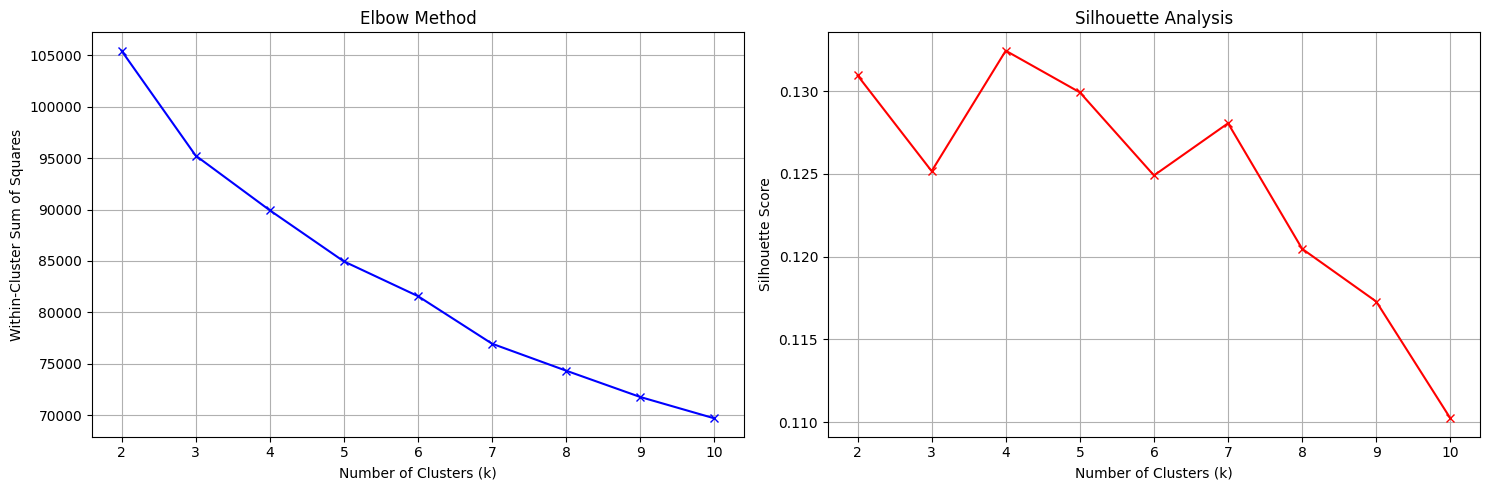

In [ ]:
# Combine processed features for clustering
cc_processed_for_clustering = pd.concat(
    [numerical_scaled_df, binary_df, categorical_encoded_df],
    axis=1
)


# Determine optimal number of clusters
wcss = [] # Within Cluster Sum of Squares
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(cc_processed_for_clustering)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(cc_processed_for_clustering, kmeans.labels_))

# Plot elbow curve and silhouette scores
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Elbow Method')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Perform K-means clustering with optimal k

optimal_k = 4  # Adjust based on the elbow plot and silhouette scores
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_churn_df['Cluster'] = kmeans.fit_predict(cc_processed_for_clustering)
cc_processed_for_clustering['Cluster'] = kmeans.fit_predict(cc_processed_for_clustering)


# Analyze clusters
# Basic cluster statistics
print("\nSizes of Each Cluster:")
print(customer_churn_df['Cluster'].value_counts().sort_index())

# Churn rate by cluster
print("\nChurn Rate by Cluster:")
cluster_churn = customer_churn_df.groupby('Cluster')['churn_value'].mean().round(3)
print(cluster_churn)

# Create detailed cluster profiles
def create_cluster_profile(cluster_data):
    profile = {}

    # Numerical features (mean)
    profile['numerical'] = cluster_data[numerical_columns].mean()

    # Binary features (proportion)
    profile['binary'] = cluster_data[binary_columns].mean()

    # Categorical features (mode)
    profile['categorical'] = {col: cluster_data[col].mode().iloc[0] for col in categorical_columns[1:]}

    # Churn rate (to identify high-risk groups)
    profile['churn_rate'] = cluster_data['churn_value'].mean()

    return profile

# Create and display profiles for each cluster
for cluster in range(optimal_k):
    customer_churn_df['churn_category'] = customer_churn['churn_category']
    customer_churn_df['churn_reason'] = customer_churn['churn_reason']
    cluster_data = customer_churn_df[customer_churn_df['Cluster'] == cluster]
    customer_profile = create_cluster_profile(cluster_data)

    print(f"\n{'='*50}")
    print(f"Cluster {cluster} Profile (Size: {len(cluster_data)})")
    print(f"Churn Rate: {customer_profile['churn_rate']:.2%}")
    print(f"Most Common Churn Category: {cluster_data['churn_category'].value_counts().index[1]}")
    print(f"Most Common Churn Reason: {cluster_data['churn_reason'].value_counts().index[1]}")

    print("\nNumerical Features (Mean):")
    print(customer_profile['numerical'].round(2))

    print("\nBinary Features (Proportion):")
    print(customer_profile['binary'].round(2))

    print("\nMost Common Categories:")
    most_offers = cluster_data['offer'].value_counts().index[1]
    print(f'offer: {most_offers}')
    for col, value in customer_profile['categorical'].items():
        print(f"{col}: {value}")


Sizes of Each Cluster:
Cluster
0    1511
1    2093
2    3099
3     340
Name: count, dtype: int64

Churn Rate by Cluster:
Cluster
0    0.073
1    0.116
2    0.468
3    0.197
Name: churn_value, dtype: float64

Cluster 0 Profile (Size: 1511)
Churn Rate: 7.35%
Most Common Churn Category: Attitude
Most Common Churn Reason: Attitude of support person

Numerical Features (Mean):
age                                    42.72
number_of_dependents                    0.77
number_of_referrals                     2.22
tenure_in_months                       29.92
total_refunds                           0.39
total_extra_data_charges                0.27
total_long_distance_charges           746.85
avg_monthly_long_distance_charges      24.86
avg_monthly_gb_download                 0.43
monthly_charge                         21.60
satisfaction_score                      3.87
cltv                                 4368.49
dtype: float64

Binary Features (Proportion):
gender                    0.51
under_3

### **Age Distribution**

We noted that while there was no particular age group which dominated the user composition for all clusters, clusters 2 and 3 contained a higher proportion of older people with respect to their cluster group.

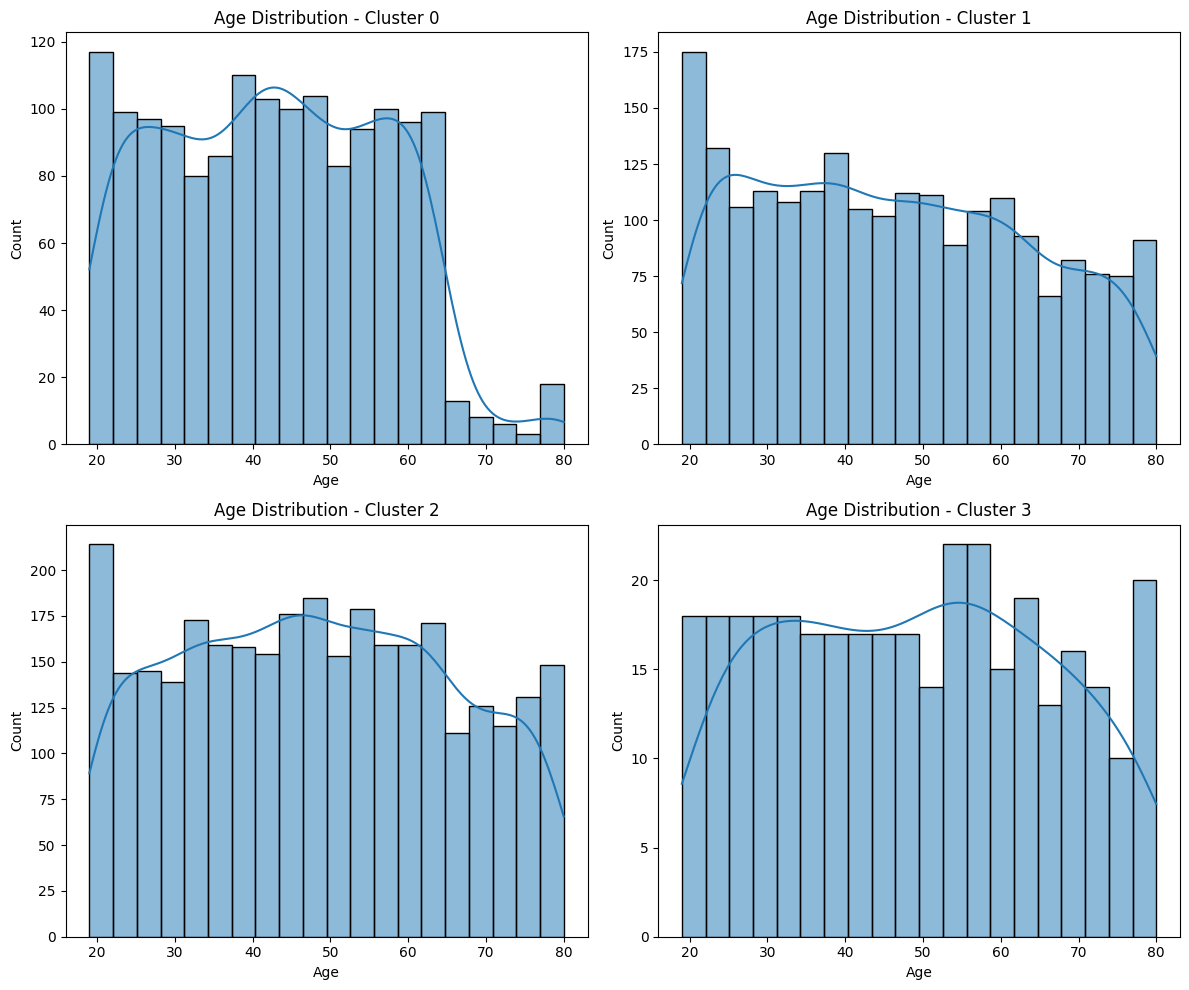

In [ ]:
# Distribution of customers' age across clusters

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Loop through each cluster (0 to 3)
for cluster in range(4):
    # Create histogram for each cluster
    sns.histplot(
        data=customer_churn_df[customer_churn_df['Cluster'] == cluster],
        x='age',
        ax=axes[cluster],
        bins=20,
        kde=True
    )

    axes[cluster].set_title(f'Age Distribution - Cluster {cluster}')
    axes[cluster].set_xlabel('Age')
    axes[cluster].set_ylabel('Count')

plt.tight_layout()
plt.show()

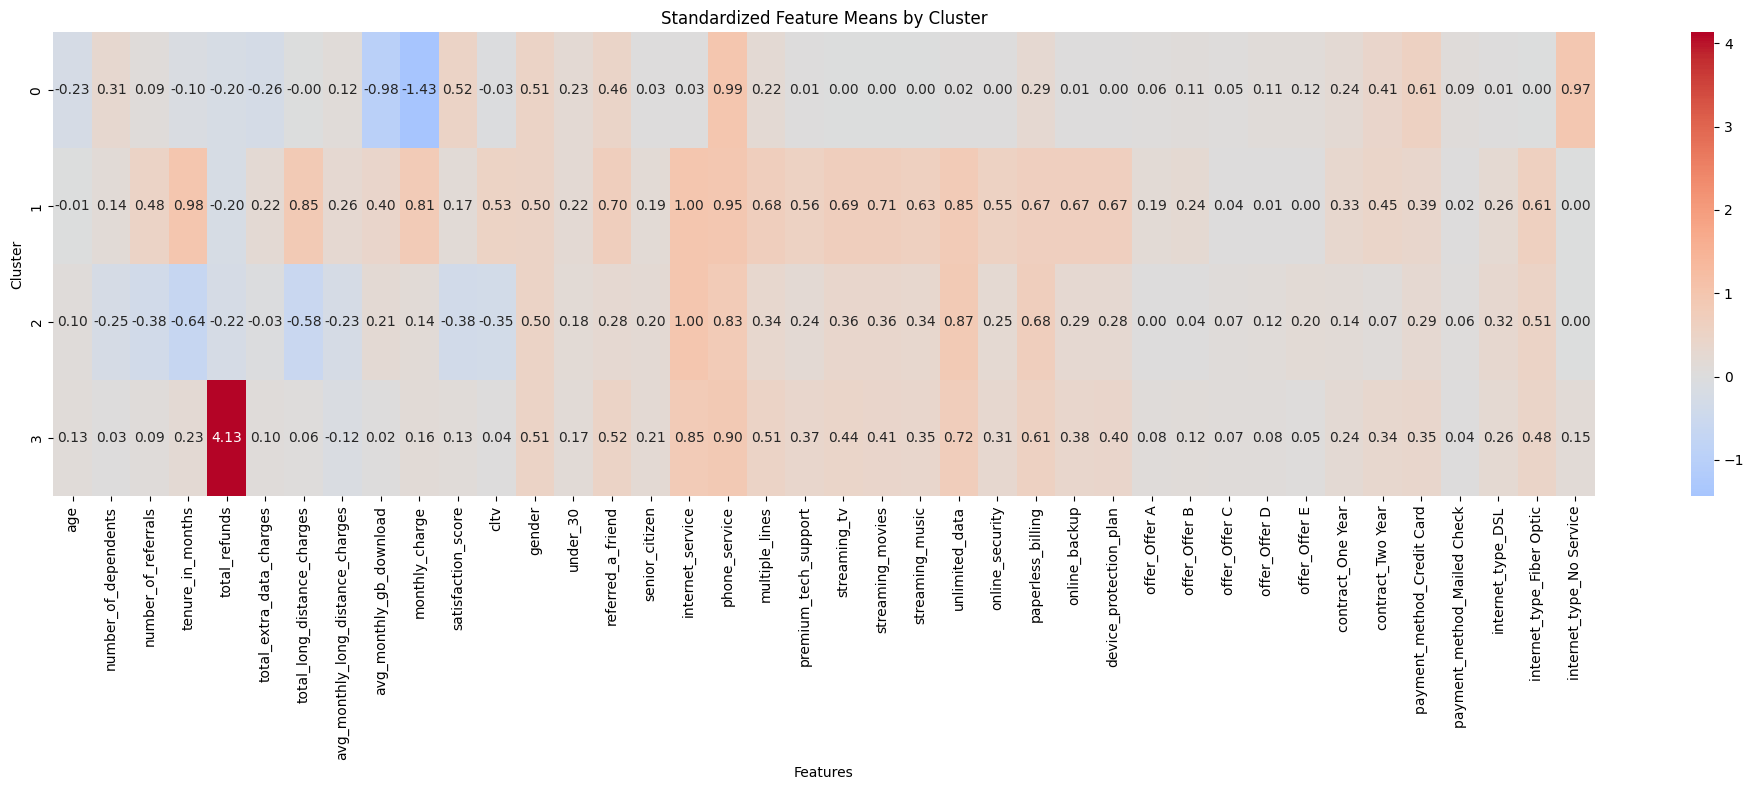

In [ ]:
# Visualize cluster characteristics
# Create heatmap of standardized feature means by cluster
# This applies the gradient to all values, not for each feature
cluster_means = cc_processed_for_clustering.groupby('Cluster').mean()
plt.figure(figsize=(20, 8))
sns.heatmap(cluster_means, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Standardized Feature Means by Cluster')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize cluster characteristics
# Feature-wise heatmap (This applies the heatmap across across clusters for each feature)
cluster_means.style.background_gradient(cmap='PuBu', axis=0)

,age,number_of_dependents,number_of_referrals,tenure_in_months,total_refunds,total_extra_data_charges,total_long_distance_charges,avg_monthly_long_distance_charges,avg_monthly_gb_download,monthly_charge,satisfaction_score,cltv,gender,under_30,referred_a_friend,senior_citizen,internet_service,phone_service,multiple_lines,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,online_security,paperless_billing,online_backup,device_protection_plan,offer_Offer A,offer_Offer B,offer_Offer C,offer_Offer D,offer_Offer E,contract_One Year,contract_Two Year,payment_method_Credit Card,payment_method_Mailed Check,internet_type_DSL,internet_type_Fiber Optic,internet_type_No Service
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-0.226102,0.311960,0.087932,-0.100630,-0.198924,-0.262491,-0.002651,0.123244,-0.983953,-1.434452,0.517147,-0.026886,0.507611,0.226340,0.458637,0.031767,0.025149,0.991396,0.215089,0.006618,0.000662,0.000000,0.000000,0.019193,0.003309,0.292522,0.005956,0.004633,0.056916,0.107214,0.054269,0.111846,0.117141,0.236929,0.405692,0.608206,0.093977,0.013236,0.000000,0.974851
1,-0.005844,0.135993,0.484272,0.979511,-0.199161,0.223455,0.853487,0.264525,0.403387,0.806829,0.167552,0.525983,0.503583,0.216914,0.704730,0.186335,1.000000,0.954133,0.682752,0.560440,0.686574,0.706163,0.634018,0.847587,0.548017,0.669374,0.665552,0.670330,0.188724,0.240803,0.041567,0.011945,0.002389,0.329670,0.446249,0.386527,0.018156,0.261347,0.610607,0.000000
2,0.099957,-0.246849,-0.380195,-0.637374,-0.221917,-0.033567,-0.581700,-0.225951,0.205373,0.136813,-0.379470,-0.346788,0.503388,0.176509,0.283317,0.203614,0.999677,0.825750,0.336237,0.237173,0.361084,0.360116,0.335915,0.869958,0.246208,0.684737,0.289448,0.282349,0.004195,0.037431,0.071959,0.123266,0.195870,0.136173,0.070668,0.291062,0.062278,0.321394,0.514682,0.000323
3,0.129716,0.026410,0.093465,0.226937,4.132760,0.096936,0.059845,-0.116620,0.017684,0.161119,0.129061,0.042469,0.511765,0.170588,0.517647,0.214706,0.847059,0.902941,0.514706,0.370588,0.441176,0.405882,0.352941,0.723529,0.305882,0.605882,0.382353,0.402941,0.076471,0.123529,0.067647,0.076471,0.047059,0.235294,0.344118,0.350000,0.035294,0.261765,0.476471,0.152941


### **Cluster Interpretation**

Following are the interpretation of the four clusters, according to the heatmap above:


**Cluster0:** The size of cluster 0 is 1511 and the churn rate is 7.35%. User profile in cluster0 is relatively young with an average age of 43. They have a tenure of around 30 months, indicating that they are established customers. They mainly order phone service(99%), and almost none have internet services. The most common plan for them is two-year contract with credit card payment. Also, they have a high satisfaction score of 3.87. Overall, Cluster 0 represents satisfied, low-risk customers with long-term contract.

**Cluster1:**  The size of cluster 1 is 2093 and the churn rate is 11.56%. User profile in cluster1 is slightly older compared with cluster0, with an average age of 46. They have the longest average tenure of around 56 months, with the highest usage of additional features e.g. streaming. All people in the cluster subscribed to internet service, which is a feature that clearly distinguishes them from those in cluster0. Their have a Moderate satisfaction of 3.45 and their value to the company is the highest(5022.52). The most common plan they choose is two-year contact with bank withdrawals. Overall, cluster 1 shows moderately stable, long-tenured customers subscribing to many extensive services, including internet services.

**Cluster2:**  The size of cluster 2 is 3099 and the churn rate is 46.76%. Most of them churned because "competitor had better devices." Compared to the previous clusters, the user profile in cluster 2 is slightly older(48.18). They are newest customers with an average tenure of 17 months. Similar to cluster1, they have high internet usage, but they have low engagement in most other services. Their satisfaction rate is 2.79 and their value to the company is comparetively lower. The most common plan they chose is month-to-month contracts. Overall, cluster 2 is a high-risk group with the highest churn rate, indicating they are customers that tend to prefer short-term contracts and less commitment so they they can transfer after contract expiry to more attractive (competitor) options if they exist.

**Cluster3:** The size of cluster 3 is the smallest with 340 and they have the highest average age (48.68) with the most 'senior citizens'. The churn rate is 19.71% and the biggest churn reason is a "better offer" from the competitor. The most common offer the customers in this group accepted is 'Offer B', which is also the most common offer accepted by all customers in the data. One noticable feature is their high total refunds, possibly due to service issues. They have moderate internet and phone service usage with varied features. For satifaction rate, they have moderate satisfaction of 3.40. Their most common plan is month-to-month contracts. Overall, cluster 3 has moderate risk, possibly needing more engagement or resolution of service issues.

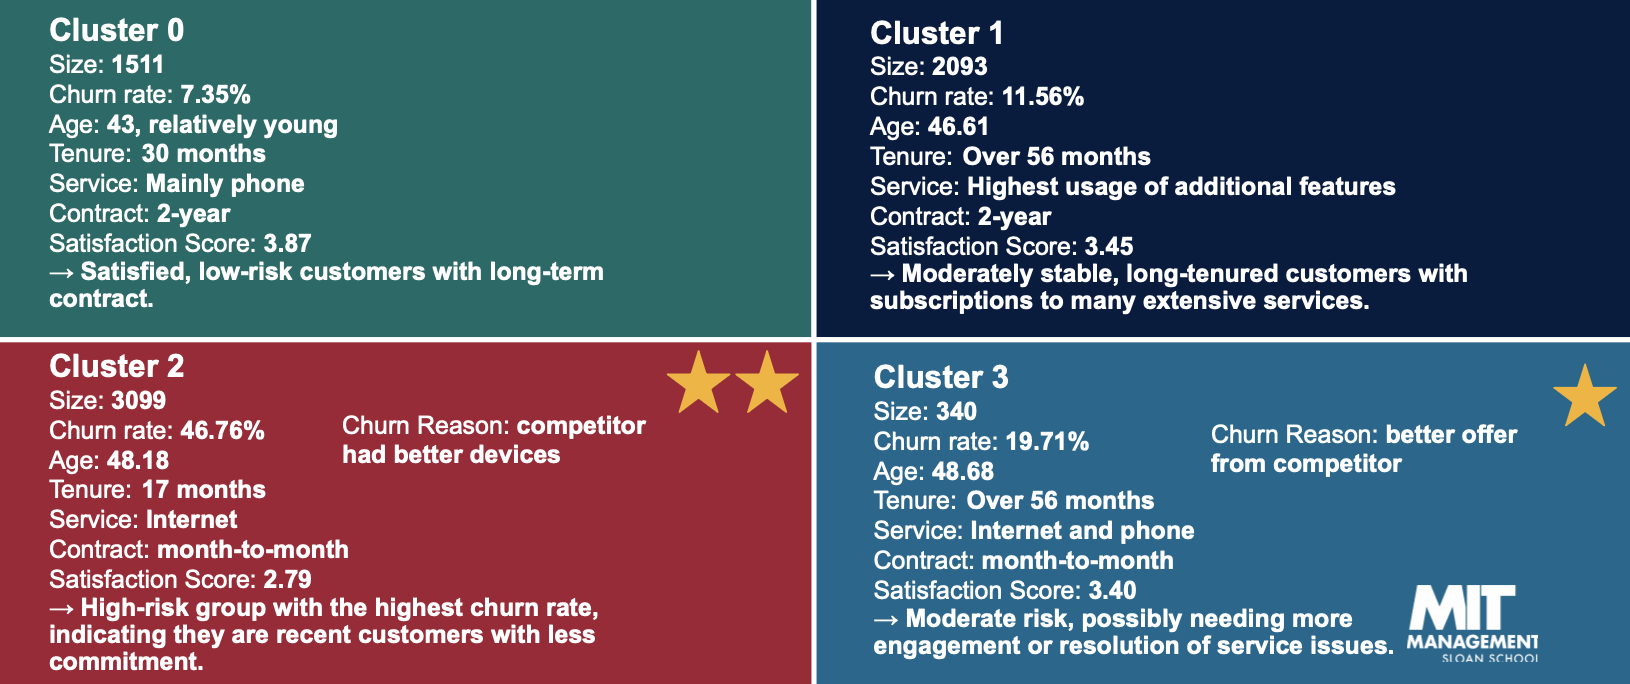

# **Predictive Modeling**

In this section, we implemented several predictive modeling methods to further understand the primary features of customers that are associated with churn.

We first used vanilla Logistic Regression, because it provides us with a straightforward interpretation regarding the relationship between the predictors and the probability of customer churn. Afterwards, we improvised on the vanilla model and further implemented Penalized Logistic Regression in an attempt to reduce overfitting and have the model generalize better to unseen data in terms of churn predictions.

Second, we used CART to identify key feature thresholds of customer behavior changes. Compared to logistic regression, CART offered a straightforward decision tree approach that excelled in capturing non-linear patterns, allowing us to obtain feature importances that result from training on these complex feature interactions and compare them to other importance results.

Third, we implemented XGBoost. XGBoost is known to boast great predictive accuracy and robustness among machine learning models, and this was used as an attempt to maximize predictive performance.

For hyperparameter tuning, we used **GridSearchCV**, which combines 5-fold cross validation and an exhaustive search over the combinations of the specified parameter values to find the best model.

## **Modeling Preparation**

### **Train-test Split**

In [ ]:
# Unstandardized dataset
# Combine binary, original numerical, and encoded categorical
X_unstandardized = pd.concat([
    binary_df,  # binary features
    customer_churn_df[numerical_columns],  # original numerical features
    categorical_encoded_df  # encoded categorical features
], axis=1)

# Standardized dataset
# Combine binary, standardized numerical, and encoded categorical
X_standardized = pd.concat([
    binary_df,  # binary features
    numerical_scaled_df,  # standardized numerical features
    categorical_encoded_df  # encoded categorical features
], axis=1)


# Response variable
y = customer_churn_df[response_column].values


# Create train-test splits
# Using stratification and random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(
    X_unstandardized,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Create standardized train-test splits
# Using same random_state and stratification for consistency
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_standardized,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# Make sure y is 1d array
y_train = y_train.ravel()
y_test = y_test.ravel()

### **Helper Functions**

Prior to modeling, we defined some helper functions to use for each model, such as hyperparameter tuning, model evaluation, confusion matrix check and feature importance plotting.

In [ ]:
# Helper functions for modeling

def hyperparameter_tuning(model, param_grid, X_train, y_train, cv=5, scoring='roc_auc'):
    """
    Performs hyperparameter tuning using GridSearchCV.
    Scoring uses 'roc_auc' for classificaiton
    """
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Best {scoring} score: {grid_search.best_score_:.4f}")

    return grid_search, grid_search.best_params_

def fit_and_evaluate_model(model, X_train, y_train, X_test, y_test, p=0.5):
    """
    Fits a model and evaluates classification metrics using probability threshold

    Parameters:
    -----------
    model : estimator object
        The classification model
    X_train, y_train : training data
    X_test, y_test : test data
    p : float, default=0.5
        Probability threshold for class prediction
    """
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

    # Get probability predictions
    train_probs = model.predict_proba(X_train)[:, 1]
    test_probs = model.predict_proba(X_test)[:, 1]

    # Convert probabilities to class predictions using threshold p
    train_preds = (train_probs > p).astype(int)
    test_preds = (test_probs > p).astype(int)

    # Calculate metrics
    metrics = {
        'train_accuracy': accuracy_score(y_train, train_preds),
        'test_accuracy': accuracy_score(y_test, test_preds),
        'train_precision': precision_score(y_train, train_preds),
        'test_precision': precision_score(y_test, test_preds),
        'train_recall': recall_score(y_train, train_preds),
        'test_recall': recall_score(y_test, test_preds),
        'train_f1': f1_score(y_train, train_preds),
        'test_f1': f1_score(y_test, test_preds),
        'train_auc': roc_auc_score(y_train, train_probs),
        'test_auc': roc_auc_score(y_test, test_probs),
        'training_time': training_time,
        'threshold': p
    }

    return model, metrics

def display_results(model_name, metrics, results_df=None):
    """
    Display classification results as a pandas dataframe
    """
    # Define columns structure
    columns = ['Model', 'Threshold', 'Train_Accuracy',
               'Test_Accuracy', 'Train_Precision',
               'Test_Precision','Train_Recall',
               'Test_Recall', 'Train_F1', 'Test_F1',
               'Train_AUC', 'Test_AUC',
               'Training_Time']

    # Create new row as a dictionary
    new_row = {
        'Model': model_name,
        'Threshold': metrics['threshold'],
        'Train_Accuracy': metrics['train_accuracy'],
        'Test_Accuracy': metrics['test_accuracy'],
        'Train_Precision': metrics['train_precision'],
        'Test_Precision': metrics['test_precision'],
        'Train_Recall': metrics['train_recall'],
        'Test_Recall': metrics['test_recall'],
        'Train_F1': metrics['train_f1'],
        'Test_F1': metrics['test_f1'],
        'Train_AUC': metrics['train_auc'],
        'Test_AUC': metrics['test_auc'],
        'Training_Time': metrics['training_time']
    }

    # If results_df doesn't exist, create it with the first row
    if results_df is None:
        results_df = pd.DataFrame([new_row], columns=columns)
    else:
        # Append new row to existing DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([new_row], columns=columns)],
                             ignore_index=True)

    return results_df


def plot_confusion_matrix(model, model_name, X_test, y_test, p=0.5):
    """
    Plots confusion matrix for classification results based on probability threshold
    """
    test_probs = model.predict_proba(X_test)[:, 1]
    predictions = (test_probs > p).astype(int)
    cm = confusion_matrix(y_test, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


def expected_profit(model, model_name, X_test, y_test, p=0.5, normal_profit=None, profit_after_cost=None, proportion=0.5):
    """
    Calculates the expected total profit according to the confusion matrix
    """
    test_probs = model.predict_proba(X_test)[:, 1]
    predictions = (test_probs > p).astype(int)
    cm = confusion_matrix(y_test, predictions)
    tn = cm[0,0]  # True Negatives (top-left)
    fp = cm[0,1]  # False Positives (top-right)
    fn = cm[1,0]  # False Negatives (bottom-left)
    tp = cm[1,1]  # True Positives (bottom-right)
    if normal_profit is not None and profit_after_cost is not None:
      expected_total_profit = tn*normal_profit + fp*profit_after_cost + fn*0 + tp*proportion*profit_after_cost
      print(f"Expected Total Profit: ${expected_total_profit}")
      return expected_total_profit


def top_feature_importance(model_name, feature_importances, feature_names, num_features_to_display=15):
    """
    Plots feature importance for models that support it
    Works with different feature importance attributes
    """

    # Create a dataframe for the feature importances
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': abs(feature_importances)
    })

    # Sort the dataframe by importance and select the top features
    top_features = feature_importance_df.sort_values(
        by='Importance',
        ascending=False
    ).head(num_features_to_display)

    top_n_features = top_features['Importance']

    # Create a colormap from dark blue to light blue
    cmap = LinearSegmentedColormap.from_list("darkblue_to_lightblue", ["lightblue", "darkblue"])

    n = len(top_n_features)
    colors = [cmap(i / (n - 1)) for i in range(n)]

    # Plot the barplot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=top_features,
        x='Importance',
        y='Feature',
        hue='Importance',
        palette=colors,
        legend = False
    )

    plt.title(f'Top {num_features_to_display} Feature Importances in {model_name}')
    plt.xlabel('Absolute Coefficient Value')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

    return top_features

## **(Vanilla) Logistic Regression**

We started with the basic Vanilla logistic regression, which provided insights into relationships between features through highly interpretable coefficient.

Based on the results shown below, the top feature influencing customer churn is the Satisfaction Score, which aligns with expectation and former analysis. Online security and Number of Referrals are surprisingly also among the top features, indicating their important influence on churn rate. The standardized coefficient of Online Security is -2.6, which indicates that those who are subscribed to the Online Security Service are less likely to churn. Through this, it can be assumed that they are quite satisfied with the Online Security Service.

For model performance, the model exhibited strong performance in predicting customer churn with relatively high accuracy, precision and AUC values, along with quick training times.

In [ ]:
# Create vanilla logistic regression model
lr_vanilla = LogisticRegression(
    max_iter=100,
    random_state=42
)

# Fit and evaluate model
lr_model, lr_metrics = fit_and_evaluate_model(
    lr_vanilla,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    p=0.5)

# Store results
results_df = display_results("Vanilla Logistic Regression (0.5)", lr_metrics)

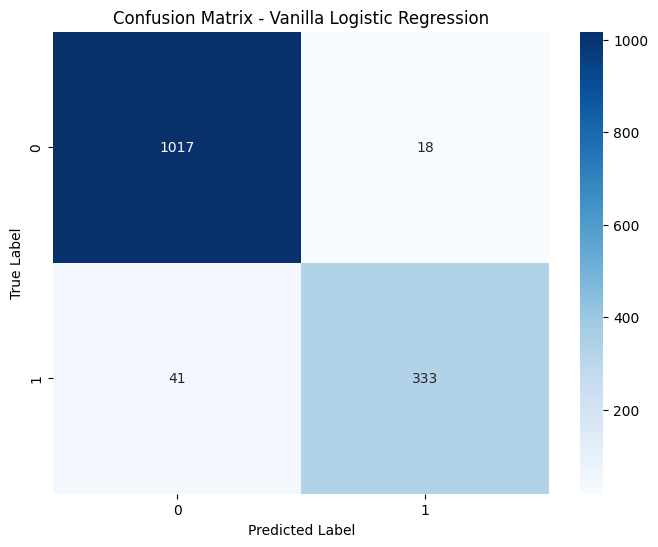

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(lr_model, "Vanilla Logistic Regression", X_test_scaled, y_test)

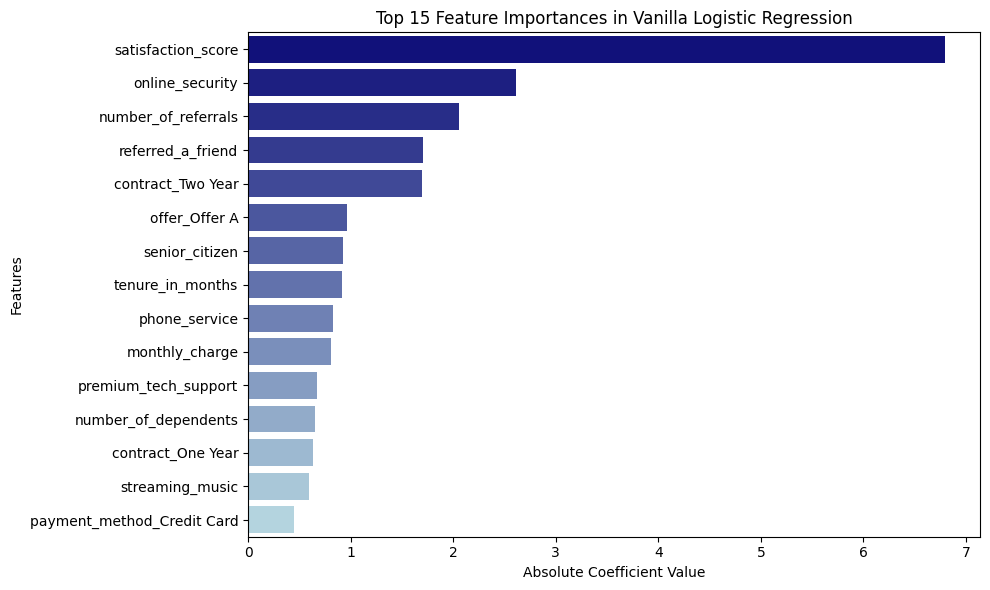

,Feature,Importance
26,satisfaction_score,6.797086
12,online_security,2.617635
18,number_of_referrals,2.054521
2,referred_a_friend,1.703377
34,contract_Two Year,1.701117
28,offer_Offer A,0.965791
3,senior_citizen,0.930312
19,tenure_in_months,0.912204
5,phone_service,0.826875
25,monthly_charge,0.811443


In [ ]:
# Plot feature importances (coefficients)
top_feature_importance(
    "Vanilla Logistic Regression",
    lr_model.coef_[0],  # Coefficients for binary classification
    X_train.columns,    # Feature names
    num_features_to_display=15
)

In [ ]:
# See the raw standardized coefficients for directional interpretation

lr_coefficients = pd.DataFrame({
        'Features': X_train.columns,
        'Standardized Coefficients': lr_model.coef_[0],
        'Importance': abs(lr_model.coef_[0])
    })

lr_top_features = lr_coefficients.sort_values(
    by='Importance',
    ascending=False
).drop('Importance', axis=1).head(15)

lr_top_features

,Features,Standardized Coefficients
26,satisfaction_score,-6.797086
12,online_security,-2.617635
18,number_of_referrals,-2.054521
2,referred_a_friend,1.703377
34,contract_Two Year,-1.701117
28,offer_Offer A,0.965791
3,senior_citizen,0.930312
19,tenure_in_months,-0.912204
5,phone_service,-0.826875
25,monthly_charge,0.811443


In [ ]:
# See results for vanilla logistic regression
results_df

,Model,Threshold,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1,Test_F1,Train_AUC,Test_AUC,Training_Time
0,Vanilla Logistic Regression (0.5),0.5,0.965744,0.958126,0.953975,0.948718,0.91505,0.890374,0.934107,0.918621,0.993572,0.991271,0.108185


## **Penalized Logistic Regression**

We proceeded to implement Penalized Logistic Regression in an attempt to have the model generalize better to unseen data in terms of churn predictions.
The penalized logistics regression model shares the same top three important features as those in Vanilla Regression: Satisfaction Score, Online Security, and
Number of Referrals.

The standardized coefficient of Number of Referrals is
−2.44, indicating that the more referrals a customer has, the less likely they are to churn. Also, longer contracts (2 years) decrease the likelihood of churn,
while a customer under Offer A are more likely to churn.

Compared with the vanilla model, the LASSO model has increased accuracy, potentially reducing overfitting and increasing model interpretability, as is shown below.

In [ ]:
# Create parameter grid for LASSO
param_grid = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  # C = 1/alpha
    'solver': ['liblinear', 'saga'],  # Only these solvers support L1
    'max_iter': [100, 200, 300]
}

# Create LASSO logistic regression model
lr_lasso = LogisticRegression(
    penalty='l1',      # LASSO
    random_state=42
)

# Perform grid search
grid_search, best_params = hyperparameter_tuning(
    lr_lasso,
    param_grid,
    X_train_scaled,
    y_train,
    cv=5,
    scoring='roc_auc'  # Using ROC-AUC for scoring
)

# Get best model
best_lasso = grid_search.best_estimator_

# Fit and evaluate best model
lasso_model, lasso_metrics = fit_and_evaluate_model(
    best_lasso,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    p=0.5
)

# Add results to our results DataFrame
results_df = display_results("LASSO Logistic Regression (0.5)", lasso_metrics, results_df)


# Print best parameters
print("\nBest Parameters:")
print(best_params)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best Hyperparameters: {'C': 1, 'max_iter': 300, 'solver': 'saga'}
Best roc_auc score: 0.9926

Best Parameters:
{'C': 1, 'max_iter': 300, 'solver': 'saga'}


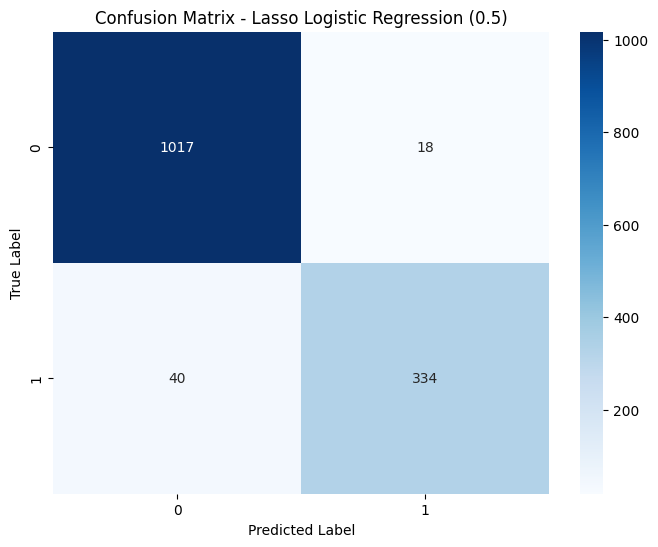

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(lasso_model, "Lasso Logistic Regression (0.5)", X_test_scaled, y_test)

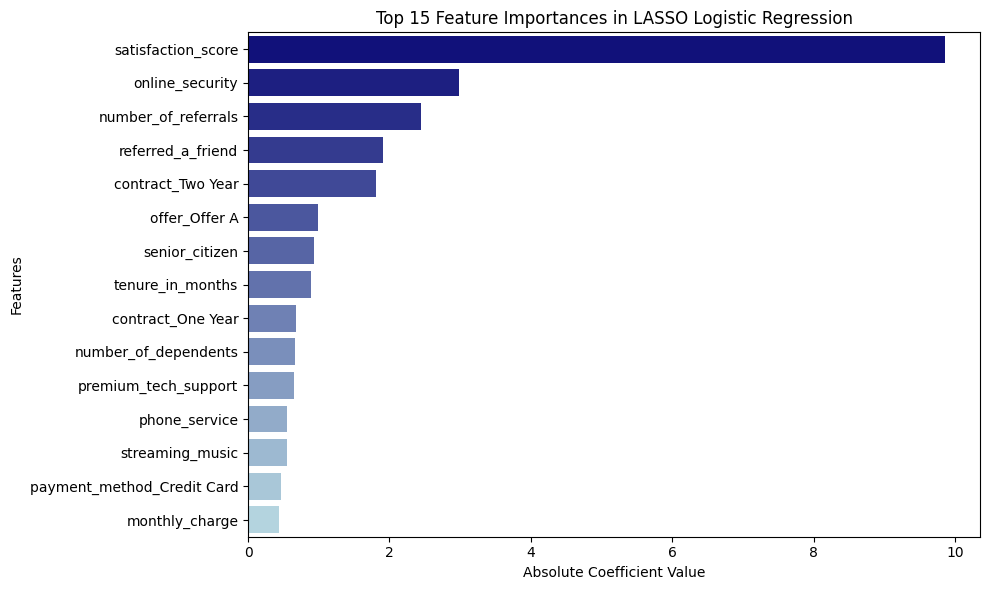

,Feature,Importance
26,satisfaction_score,9.861319
12,online_security,2.990188
18,number_of_referrals,2.443031
2,referred_a_friend,1.913596
34,contract_Two Year,1.815718
28,offer_Offer A,0.987866
3,senior_citizen,0.930650
19,tenure_in_months,0.892381
33,contract_One Year,0.671938
17,number_of_dependents,0.669957


In [ ]:
# Plot feature importances
top_feature_importance(
    "LASSO Logistic Regression",
    lasso_model.coef_[0],
    X_train_scaled.columns,
    num_features_to_display=15
)

In [ ]:
# See the raw coefficients for directional interpretation

lasso_lr_coefficients = pd.DataFrame({
        'Features': X_train.columns,
        'Standardized Coefficients': lasso_model.coef_[0],
        'Importance': abs(lasso_model.coef_[0])
    })

lasso_lr_top_features = lasso_lr_coefficients.sort_values(
    by='Importance',
    ascending=False
).drop('Importance', axis=1).head(15)

lasso_lr_top_features

,Features,Standardized Coefficients
26,satisfaction_score,-9.861319
12,online_security,-2.990188
18,number_of_referrals,-2.443031
2,referred_a_friend,1.913596
34,contract_Two Year,-1.815718
28,offer_Offer A,0.987866
3,senior_citizen,0.930650
19,tenure_in_months,-0.892381
33,contract_One Year,-0.671938
17,number_of_dependents,-0.669957


In [ ]:
# See results for penalized logistic regression
print("\nComparison with Previous Model:")
results_df


Comparison with Previous Model:


,Model,Threshold,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1,Test_F1,Train_AUC,Test_AUC,Training_Time
0,Vanilla Logistic Regression (0.5),0.5,0.965744,0.958126,0.953975,0.948718,0.915050,0.890374,0.934107,0.918621,0.993572,0.991271,0.108185
1,LASSO Logistic Regression (0.5),0.5,0.965566,0.958836,0.951423,0.948864,0.917057,0.893048,0.933924,0.920110,0.993707,0.991483,1.788501


One critical caveat with these two logistic regressions is that the coefficients for ’number of referrals’ and ’referred a friend’ point in opposite directions, making it challenging to determine the exact impact of the referral strategy on customer retention. This suggests that the relationship between referrals and churn risk is not perfectly captured by simple logistic regression approach. Further steps to address this potential issue can be found in the 'Telco's Customer Retention Strategy' section at the end of the report.

One possible explanation is that a customer with a high number of referrals is less
likely to churn, reflecting genuine endorsement of the service. While in
contrast, customers with few referrals might be more interested in one-time
promo credits rather than true loyalty or long-term endorsement of the service.

## **CART**


The advantage of CART lies in its ability to capture non-linear relationships. Comparing the feature importances resulting from CART along with the major features extracted from logistic regression would allow us to be more confident about which features are more associated with churn risk.

As in the logistic regression models, Satisfaction Score was the dominant factor in predicting churn. In addition, Online Security, Monthly Charge, Number of Referrals, and Tenure in Months were also influential in the model’s predictions.

Compared with logistic regression
models, CART's training was quick and quite precise, although it did show a slight drop in performance on test data compared to training data, which could suggest mild overfitting.

In [ ]:
# Create parameter grid for CART
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 20],
    'min_samples_leaf': [1, 3, 5, 7, 9, 11, 13],
    'max_features': [None],
    'criterion': ['gini']
}

# Create CART model
cart = DecisionTreeClassifier(random_state=42)

# Perform grid search
grid_search, best_params = hyperparameter_tuning(
    cart,
    param_grid,
    X_train,
    y_train,
    cv=5,
    scoring='roc_auc'
)

# Get best model
best_cart = grid_search.best_estimator_

# Fit and evaluate best model
cart_model, cart_metrics = fit_and_evaluate_model(
    best_cart,
    X_train,
    y_train,
    X_test,
    y_test,
    p=0.5
)

# Add results to the results DataFrame
results_df = display_results("CART (0.5)", cart_metrics, results_df)


# Print best parameters
print("\nBest Parameters:")
print(best_params)

Fitting 5 folds for each of 315 candidates, totalling 1575 fits
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 20}
Best roc_auc score: 0.9854

Best Parameters:
{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 20}


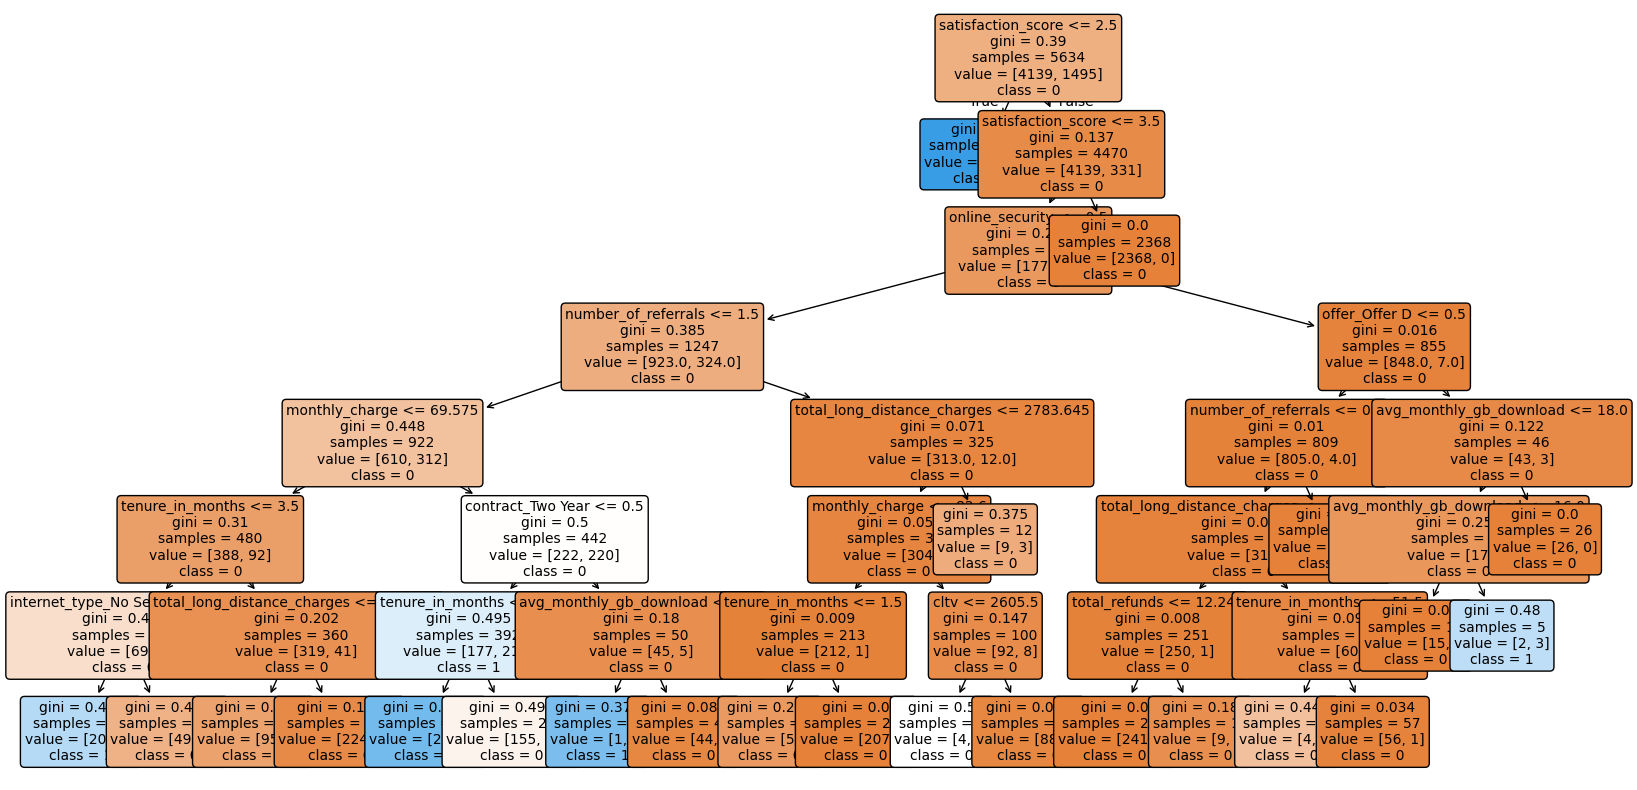

In [ ]:
# Tree visualization
plt.figure(figsize=(20,10))
plot_tree(cart_model,
          feature_names=X_train.columns,
          class_names=['0', '1'],
          filled=True,
          rounded=True,
          fontsize=10,
          max_depth=best_params['max_depth'])
plt.show()

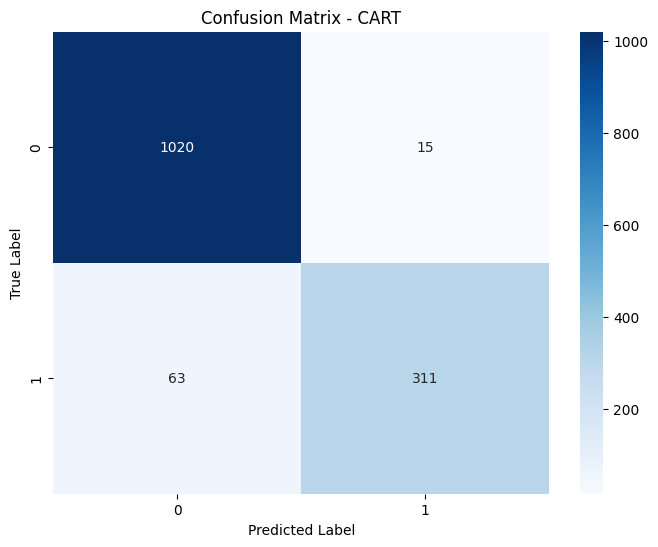

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(cart_model, "CART", X_test, y_test)

<ipython-input-40-019e39942cbb>:167: UserWarning: The palette list has more values (15) than needed (13), which may not be intended.
  sns.barplot(


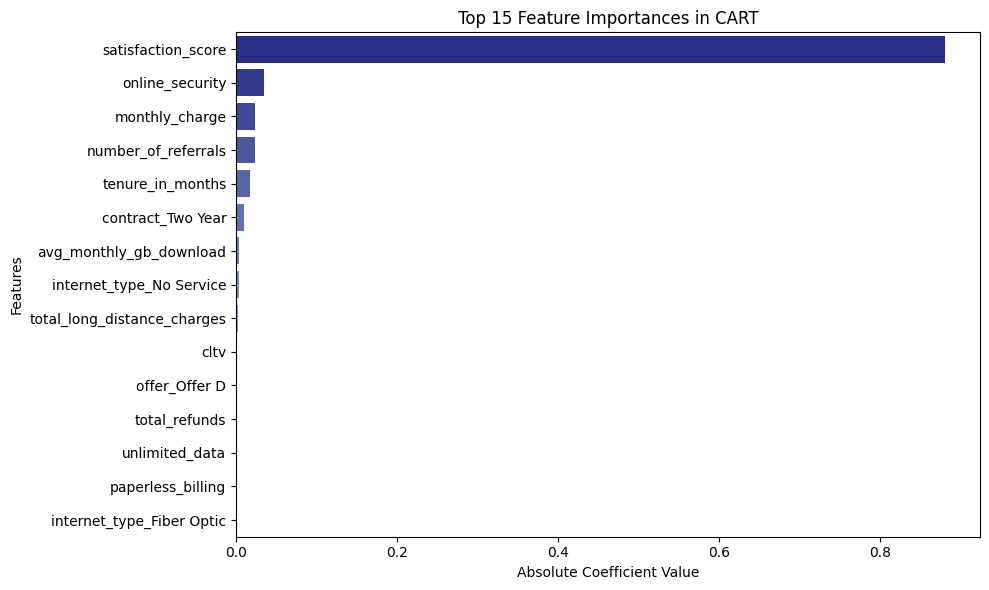

,Feature,Importance
26,satisfaction_score,0.880135
12,online_security,0.034498
25,monthly_charge,0.023568
18,number_of_referrals,0.023491
19,tenure_in_months,0.017104
34,contract_Two Year,0.009579
24,avg_monthly_gb_download,0.003696
39,internet_type_No Service,0.003573
22,total_long_distance_charges,0.002435
27,cltv,0.001648


In [ ]:
# Plot feature importances using our helper function
top_feature_importance(
    "CART",
    cart_model.feature_importances_,  # CART uses feature_importances_ instead of coefficients
    X_train.columns,
    num_features_to_display=15
)

In [ ]:
# Compare with previous models
print("\nComparison with Previous Models:")
results_df


Comparison with Previous Models:


,Model,Threshold,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1,Test_F1,Train_AUC,Test_AUC,Training_Time
0,Vanilla Logistic Regression (0.5),0.5,0.965744,0.958126,0.953975,0.948718,0.915050,0.890374,0.934107,0.918621,0.993572,0.991271,0.108185
1,LASSO Logistic Regression (0.5),0.5,0.965566,0.958836,0.951423,0.948864,0.917057,0.893048,0.933924,0.920110,0.993707,0.991483,1.788501
2,CART (0.5),0.5,0.953319,0.944642,0.965961,0.953988,0.854181,0.831551,0.906638,0.888571,0.992452,0.985680,0.023049


## **XGBoost**

To maximize predictive performance, we implemented XGBoost, which is known to boast great predictive accuracy and robustness among machine learning models.

In XGBoost, Satisfaction Score was still the most influential feature. Other important features include: Internet Type (Fiber Optic), Online Security, Senior Citizen, Contract Type (Two Year). The feature *Senior Citizen* ranked the fourth in importance, indicating that senior customers are more likely to churn, which aligns with our findings in descriptive analysis.

In terms of model performance, the XGBoost model exhibited exceptional predictive performance with high accuracy and precision. High AUC values shows its ability to effectively differentiate churn and non-churn customers. Overall, the model was robust and
efficient.

In [ ]:
# Create parameter grid for XGBoost
param_grid = {
    # Tree Parameters
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],  # minimum loss reduction for split

    # Regularization Parameters
    'reg_alpha': [0, 0.1, 1.0],  # L1 regularization (LASSO)

    # Learning Parameters
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],

    # Class weights
    'scale_pos_weight': [1, sum(y_train==0)/sum(y_train==1)]  # Account for class weights
}

# Create XGBoost model
xgb = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='auc'
)


# Perform grid search
grid_search, best_params = hyperparameter_tuning(
    xgb,
    param_grid,
    X_train_scaled,  # XGBoost with LASSO benefits from scaled features
    y_train,
    cv=5,
    scoring='roc_auc'
)

# Get best model
best_xgb = grid_search.best_estimator_


# Fit and evaluate best model
xgb_model, xgb_metrics = fit_and_evaluate_model(
    best_xgb,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    p=0.5
)

# Add results to our results DataFrame
results_df = display_results("XGBoost (0.5)", xgb_metrics, results_df)

# Print best parameters
print("\nBest Parameters:")
print(best_params)


Fitting 5 folds for each of 1944 candidates, totalling 9720 fits
Best Hyperparameters: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 1.0, 'scale_pos_weight': 1}
Best roc_auc score: 0.9933

Best Parameters:
{'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'reg_alpha': 1.0, 'scale_pos_weight': 1}


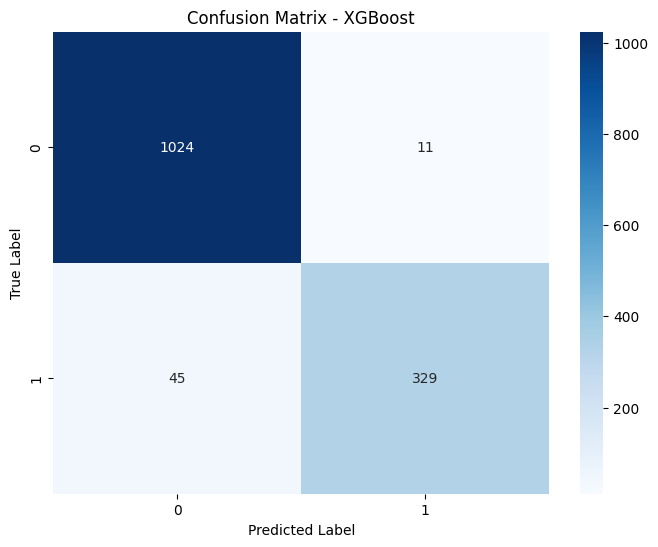

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(xgb_model, "XGBoost", X_test_scaled, y_test)

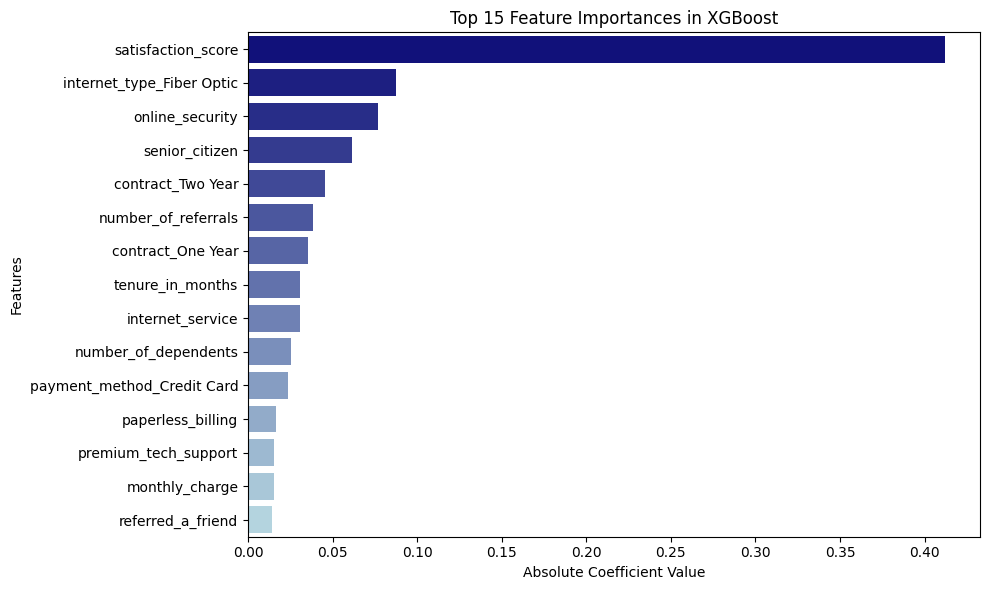

,Feature,Importance
26,satisfaction_score,0.412117
38,internet_type_Fiber Optic,0.087762
12,online_security,0.076553
3,senior_citizen,0.061306
34,contract_Two Year,0.045274
18,number_of_referrals,0.038472
33,contract_One Year,0.035283
19,tenure_in_months,0.030984
4,internet_service,0.030530
17,number_of_dependents,0.025693


In [ ]:
# Plot feature importances using our helper function
# This is based on 'weight' for XGB
top_feature_importance(
    "XGBoost",
    xgb_model.feature_importances_,
    X_train_scaled.columns,
    num_features_to_display=15
)

<Figure size 1000x600 with 0 Axes>

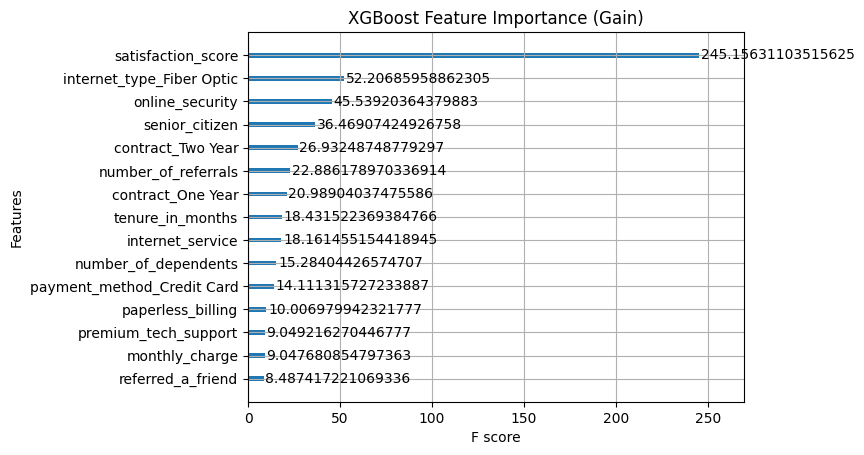

In [ ]:
# Plot feature importances based on 'gain'
# Use xgb's plot_importance
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, max_num_features=15, importance_type='gain')
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

In [ ]:
# Compare with previous models
print("\nComparison with Previous Models:")
results_df


Comparison with Previous Models:


,Model,Threshold,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1,Test_F1,Train_AUC,Test_AUC,Training_Time
0,Vanilla Logistic Regression (0.5),0.5,0.965744,0.958126,0.953975,0.948718,0.915050,0.890374,0.934107,0.918621,0.993572,0.991271,0.108185
1,LASSO Logistic Regression (0.5),0.5,0.965566,0.958836,0.951423,0.948864,0.917057,0.893048,0.933924,0.920110,0.993707,0.991483,1.788501
2,CART (0.5),0.5,0.953319,0.944642,0.965961,0.953988,0.854181,0.831551,0.906638,0.888571,0.992452,0.985680,0.023049
3,XGBoost (0.5),0.5,0.971778,0.960256,0.977143,0.967647,0.915050,0.879679,0.945078,0.921569,0.995499,0.992358,0.200464


# **Granular Churn Analysis**

From the results of the modeling, we can observe that a common feature that is present as an important predictor of churn for **all models** (besides *satisfaction_score*) is ***online_security***, which is an indicator if the customer subscribes to an additional online security service provided by the company. Given some additional context, it is possible to make more strategic decisions centered around this predictor, as well as other important predictors.

In this section, we implement a more stylized analysis that depends on business decisions using a hypothetical scenario, and discuss as how they impact our previous modeling results.

## **Scenario Description**

Let us suppose that after predictive modeling, Telco has conducted market research on installing **additional online security services** for its customers upon discovering its feature importance across all models (as we have observed above), and concluded that providing additional online security services to the customer for free halves the risk of churn for a customer.

According to the Telco data (refer to the ***Descriptive Analysis*** section), the mean of the monthly charge is approximately $\$65$.

Based on this figure, we will assume that the monthly profit Telco gains per customer is $\$50$, and additionaly installing online security services further reduces the profit to $\$40$.

Therefore, if the customer does not churn, Telco can gain a monthly profit of $\$50$   (without additional service) or $\$40$ (with additional service).

The diagram below shows all possible cases, assuming the churn probability of $p$:

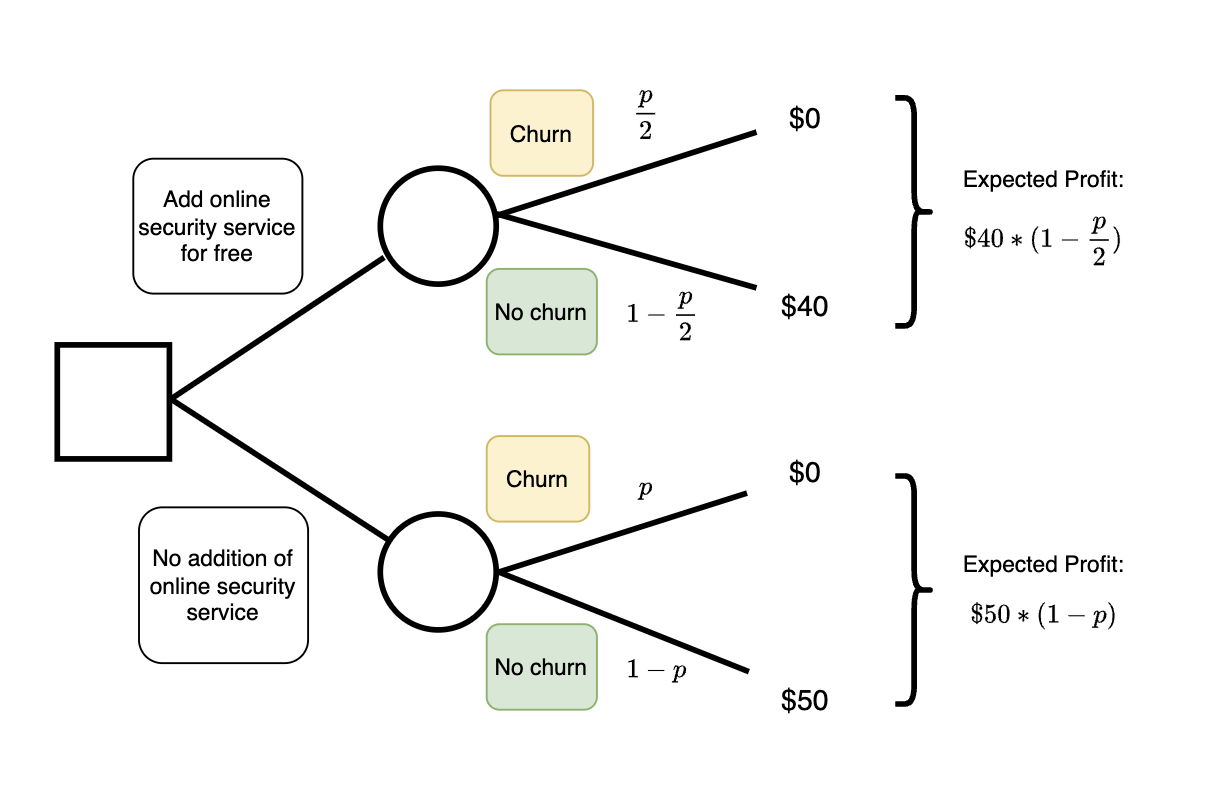

For the additional of online security services to be profitable per customer, its expected profit must be larger than the expected profit if Telco did not provide the additional online security service:

$$\$40*(1-\frac{p}{2}) > \$50*(1-p)$$

In other words, $p > 0.333$. This is the decision threshold to determine whether Telco should provide additional online security services for the customer. We apply this new threshold to the previous models, and observe the expected total profit for each case as well as compare the results.

## **Differentiated Losses**

Our scenario is equivalent to having a specific **loss matrix** (see table below), where the loss for the False Positive is \$10 and the loss for the False Negative is \$20. The loss for the False Positive is \$10 because Telco is deciding to provide additional online security services for customer retention when it actually doesn't need to, leading to a \$10 less profit (\$50 --> \$40). The loss for the False Negative is \$20 because Telco is deciding not to provide the services to those that would churn. If Telo had provided the online security services to those in the False Negative segment, the company would have gained $0.5 * 40 = 20$(\$) instead of \$0 since the risk of churning would have been reduced to half.

Therefore, the decision threshold is changed from 0.5 to allow the model to have a tendency of predicting more positives than negatives to account for the higher cost of having false negatives:

$$p > \frac{1}{1 + \left(\frac{C_{10}}{C_{01}}\right)} = \frac{1}{1 + \left(\frac{20}{10}\right)} = \frac{1}{3} = 0.333$$



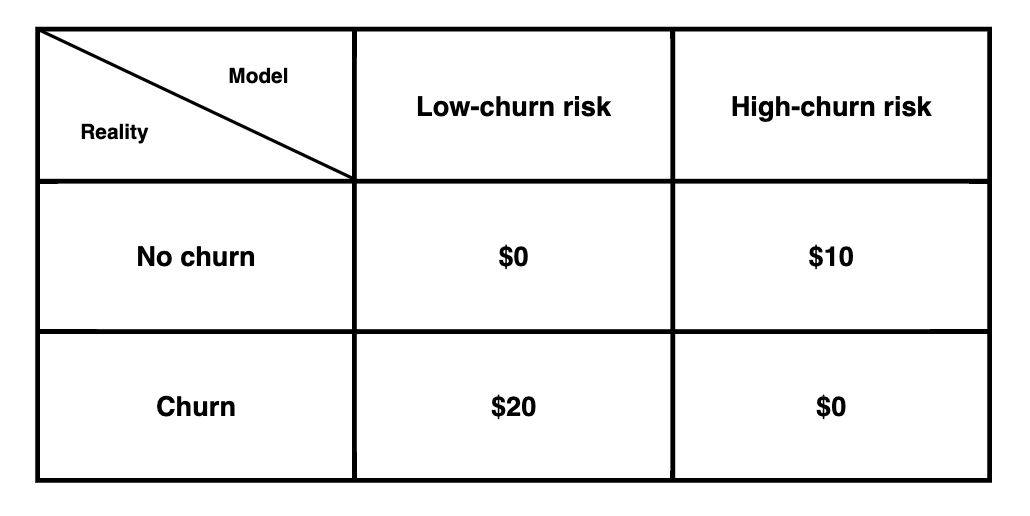

## **Expected Profit**

For each model, we create a new confusion matrix based on our updated threshold of $p = 0.333$, and calculated the expected profit as follows:

$$E[total\_profit] = TN*normal\_profit + FP*profit\_after\_cost + FN*0 + TP*0.5*profit\_after\_cost$$

Where TN = True Negative, FP = False Positive, FN = False Negative, TP = True Positive

In our case,

*normal_profit* = \$50, and
*profit_after_cost* = \$40.

**True Negative** implies that customers did not churn while no additional services were provided. Therefore, we multiply the number of people in the True Positive category by the *normal_profit*.

**False Positive** implies that customers did not churn but Telco still provided the additional service. Therefore, we multiply the number of people in the False Positive category by the *profit_after_cost*.

**False Negative** implies that the customers churned while Telco did not provide any additional services. Therefore, the number of people on the False Negative category is multiplied by 0.

**True Positive** is a situation where Telco provides the additional online security services to the customers who would have churned had there been no such service. The assumption was that **providing the online security service halves the risk of churn**. Therefore, we multiply the number of people in the True Positive category by 0.5 (meaning that half of the people in this category did not churn after receiving the service), and further multiply the value by *profit_after_cost*.

Using this formula and the new threshold, we calculate the expected total profit for each model, shown below.

## **(Vanilla) Logistic Regression**

In [ ]:
# Fit and evaluate model
lr_model, lr_metrics_new = fit_and_evaluate_model(
    lr_vanilla,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    p=0.333)

# Store results
results_df = display_results("Vanilla Logistic Regression (0.333)", lr_metrics_new, results_df)

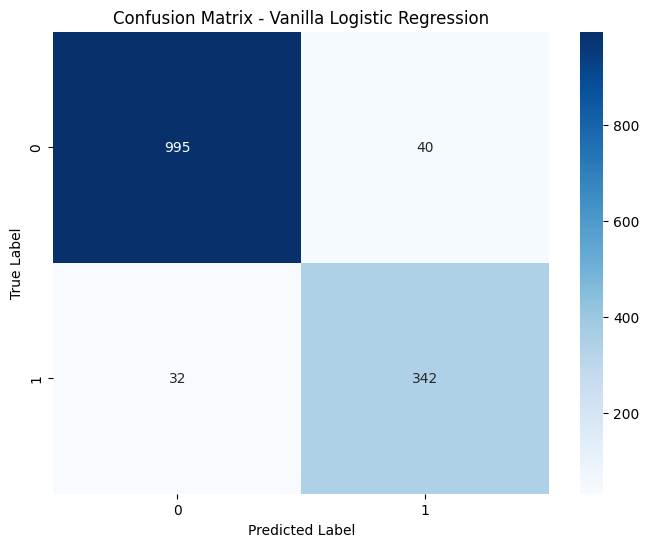

In [ ]:
# Confusion matrix
plot_confusion_matrix(lr_model, "Vanilla Logistic Regression", X_test_scaled, y_test, p=0.333)

In [ ]:
# Expected total profit
lr_exp_profit = expected_profit(lr_model, "Vanilla Logistic Regression", X_test_scaled, y_test,
                      p=0.333, normal_profit=50, profit_after_cost=40, proportion=0.5)

Expected Total Profit: $58190.0


## **Penalized Logistic Regression**

In [ ]:
# Fit and evaluate model
lasso_model, lasso_metrics_new = fit_and_evaluate_model(
    best_lasso,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    p=0.333
)

# Add results to our results DataFrame
results_df = display_results("LASSO Logistic Regression (0.333)", lasso_metrics_new, results_df)

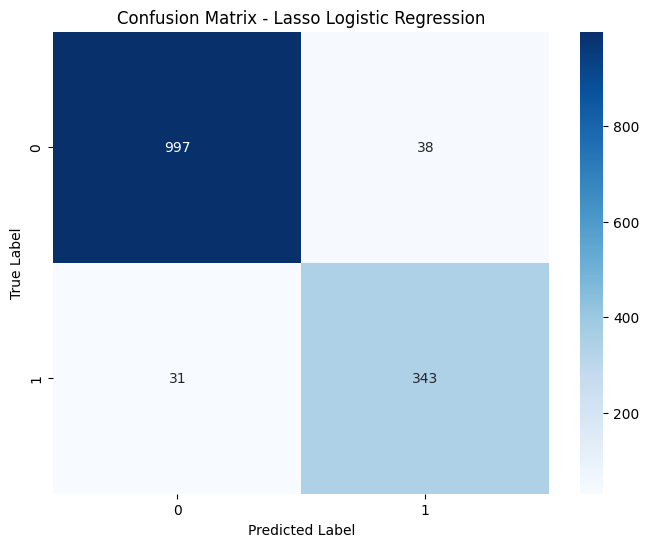

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(lasso_model, "Lasso Logistic Regression", X_test_scaled, y_test, p=0.333)

In [ ]:
# Expected total profit
lasso_lr_exp_profit = expected_profit(lasso_model, "Lasso Logistic Regression", X_test_scaled, y_test,
                      p=0.333, normal_profit=50, profit_after_cost=40, proportion=0.5)

Expected Total Profit: $58230.0


## **CART**

In [ ]:
# Fit and evaluate model
cart_model, cart_metrics_new = fit_and_evaluate_model(
    best_cart,
    X_train,
    y_train,
    X_test,
    y_test,
    p=0.333
)

# Add results to the results DataFrame
results_df = display_results("CART (0.333)", cart_metrics_new, results_df)

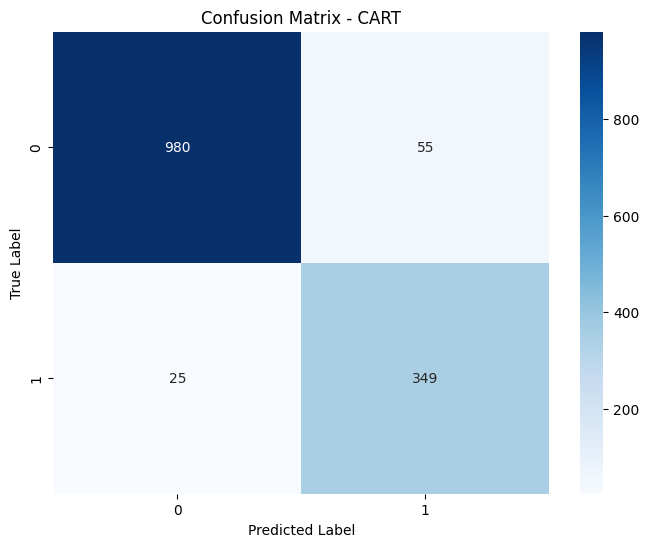

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(cart_model, "CART", X_test, y_test, p=0.333)

In [ ]:
# Expected total profit
cart_exp_profit = expected_profit(cart_model, "CART", X_test, y_test,
                      p=0.333, normal_profit=50, profit_after_cost=40, proportion=0.5)

Expected Total Profit: $58180.0


## **XGBoost**

In [ ]:
# Fit and evaluate model
xgb_model, xgb_metrics_new = fit_and_evaluate_model(
    best_xgb,
    X_train_scaled,
    y_train,
    X_test_scaled,
    y_test,
    p=0.333
)

# Add results to our results DataFrame
results_df = display_results("XGBoost (0.333)", xgb_metrics_new, results_df)

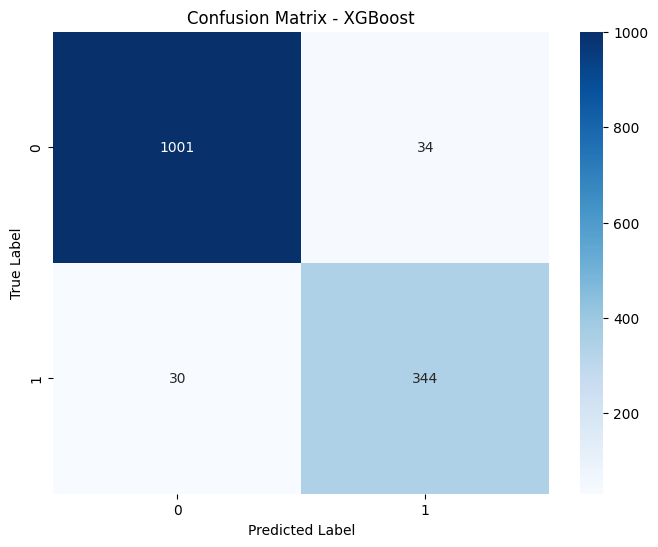

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(xgb_model, "XGBoost", X_test_scaled, y_test, p=0.333)

In [ ]:
# Expected total profit
xgb_exp_profit = expected_profit(xgb_model, "XGBoost", X_test_scaled, y_test,
                      p=0.333, normal_profit=50, profit_after_cost=40, proportion=0.5)

Expected Total Profit: $58290.0


## **Model Comparison**

In [ ]:
# Compare all models
display(results_df)

,Model,Threshold,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1,Test_F1,Train_AUC,Test_AUC,Training_Time
0,Vanilla Logistic Regression (0.5),0.500,0.965744,0.958126,0.953975,0.948718,0.915050,0.890374,0.934107,0.918621,0.993572,0.991271,0.108185
1,LASSO Logistic Regression (0.5),0.500,0.965566,0.958836,0.951423,0.948864,0.917057,0.893048,0.933924,0.920110,0.993707,0.991483,1.788501
2,CART (0.5),0.500,0.953319,0.944642,0.965961,0.953988,0.854181,0.831551,0.906638,0.888571,0.992452,0.985680,0.023049
3,XGBoost (0.5),0.500,0.971778,0.960256,0.977143,0.967647,0.915050,0.879679,0.945078,0.921569,0.995499,0.992358,0.200464
4,Vanilla Logistic Regression (0.333),0.333,0.958821,0.948900,0.896422,0.895288,0.955184,0.914439,0.924870,0.904762,0.993572,0.991271,0.071516
5,LASSO Logistic Regression (0.333),0.333,0.958289,0.951029,0.896725,0.900262,0.952508,0.917112,0.923776,0.908609,0.993707,0.991483,2.760382
6,CART (0.333),0.333,0.950302,0.943222,0.872471,0.863861,0.951839,0.933155,0.910429,0.897172,0.992452,0.985680,0.059830
7,XGBoost (0.333),0.333,0.965034,0.954578,0.918710,0.910053,0.952508,0.919786,0.935304,0.914894,0.995499,0.992358,2.169277


In [ ]:
# Check which model performs well in each metric via heatmap
results_df.style.background_gradient(cmap='YlGn', axis=0)

,Model,Threshold,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1,Test_F1,Train_AUC,Test_AUC,Training_Time
0,Vanilla Logistic Regression (0.5),0.500000,0.965744,0.958126,0.953975,0.948718,0.915050,0.890374,0.934107,0.918621,0.993572,0.991271,0.108185
1,LASSO Logistic Regression (0.5),0.500000,0.965566,0.958836,0.951423,0.948864,0.917057,0.893048,0.933924,0.920110,0.993707,0.991483,1.788501
2,CART (0.5),0.500000,0.953319,0.944642,0.965961,0.953988,0.854181,0.831551,0.906638,0.888571,0.992452,0.985680,0.023049
3,XGBoost (0.5),0.500000,0.971778,0.960256,0.977143,0.967647,0.915050,0.879679,0.945078,0.921569,0.995499,0.992358,0.200464
4,Vanilla Logistic Regression (0.333),0.333000,0.958821,0.948900,0.896422,0.895288,0.955184,0.914439,0.924870,0.904762,0.993572,0.991271,0.071516
5,LASSO Logistic Regression (0.333),0.333000,0.958289,0.951029,0.896725,0.900262,0.952508,0.917112,0.923776,0.908609,0.993707,0.991483,2.760382
6,CART (0.333),0.333000,0.950302,0.943222,0.872471,0.863861,0.951839,0.933155,0.910429,0.897172,0.992452,0.985680,0.059830
7,XGBoost (0.333),0.333000,0.965034,0.954578,0.918710,0.910053,0.952508,0.919786,0.935304,0.914894,0.995499,0.992358,2.169277


## **Expected Profit Comparison**

Comparison shows that expected profit is maximized when using the XGBoost (0.333) model for classification. This is not surprising given its excellent out-of-sample performance, which would minimize unnecessary costs from wrongly predicting positive or negative. In this hypothetical case, offering promotional online security service is proved to be an effective retention strategy with XGBoost being the best predictive model.

In [ ]:
# Expected profit for all baselines and models

normal_profit=50
profit_after_cost=40
proportion = 0.5
p = 0.333
X_test_probs = cart_model.predict_proba(X_test)[:, 1]
y_pred = (X_test_probs > p).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Baseline expected profit
no_churn = cm[0,0] + cm[0,1]
churn = cm[1,0] + cm[1,1]
no_service = no_churn * normal_profit + churn * 0
all_service = no_churn * profit_after_cost + churn * proportion * profit_after_cost

# Comparison of expected profit across the baselines and models
models = ['Service Not Provided to Anyone','Vanilla Logistic Regression (0.333)', 'LASSO Logistic Regression (0.333)',
          'CART (0.333)', 'XGBoost (0.333)', 'Service Provided to Everyone']
expected_profit = [no_service, lr_exp_profit, lasso_lr_exp_profit, cart_exp_profit, xgb_exp_profit, all_service]

expected_profit_df = pd.DataFrame(expected_profit, columns = ['Expected Profit'], index = models)
display(expected_profit_df)

,Expected Profit
Service Not Provided to Anyone,51750.0
Vanilla Logistic Regression (0.333),58190.0
LASSO Logistic Regression (0.333),58230.0
CART (0.333),58180.0
XGBoost (0.333),58290.0
Service Provided to Everyone,48880.0


# **Modeling Conclusion**

Depending on Telco's objectives, they can use different models for actionable decisions. Out of all models we have experimented with, we have decided to settle on the following to apply to Telco's analytics solutions.


- Holistic Strategy: **LASSO Logistic Regression**

The main advantage of the logistic regression model (both vanilla and penalized model) is its interpretability. It describes the linear relationship between the features and the log-odds, which is positively correlated with the probabilty of the binary outcome. More importantly, we can understand the *directional association* of the predictors, which adds to the granularity of the analysis. For example, both the vanilla and penalized logistic regression model results imply that customers who are provided online security services, makes more referrals, have premium tech support, make longer-period contracts tend to have *less* risk of churning. Therefore the logistic regression model is the most appropriate for devising *general strategies* and *future directions* of the company's business.

The high AUC score observed in the LASSO logistic regression model (>0.99) provide additional confidence in their reliability. An AUC of this magnitude indicates that the models demonstrate strong discriminative ability, successfully ranking positive instances with higher predicted probabilities than negative instances. This exceptional performance suggests that the models have effectively captured meaningful patterns in the data, lending credibility to their overall validity and subsequent interpretations.


- Predictive Performance: **XGBoost (0.5)**

When Telco wants to correctly estimate the probability of a new customer churning to devise specific targeting strategies (such as direct marketing, personalized pricing/promotions), XGBoost displays the best performance. It outperforms all other models on almost every classification metric, meaning that it can generalize extremely well on unseen data. A known limitation of XGBoost is its training cost. However, it is mainly the hyperparameter tuning (to search for the 'best' model) which takes a long time to complete. The training time using the configured best model actually was less than that of the LASSO logistic regression model. Therefore, even if new data comes in on daily and requires retraining of the same model on a frequent basis for updating, XGBoost can be a very suitable choice among our model candidates.


- Profit Maximization: **XGBoost (0.333)**

In terms of implementing a specific strategy for customer retention and profit maximization, the XGBoost (0.333) model is the most appropriate choice. Of course, this was accompanied by a hypothetical scenario that assumed clear knowledge of the impact of business decisions after market research (such as churn risk being halved per customer by proving additional online security services). This analysis was implemented to demonstrate the flexibility of setting different losses for false positives and false negatives, and therefore artificially changing the decision threshold to accomodate certain situations. Healthcare domains often adopt this methodology, especially when the loss of incorrectly predicting negative for a medical condition tends to be more costly compared to incorrectly predicting positive for the medical condition. Therefore, just like the scenario of profit maximization, this method is most appropriate when there is a clear understanding of the losses involved for incorrect predictions.


An important point to consider is that the XGBoost (0.5) and the XGBoost (0.333) have the same underlying model, since the Grid Search utilized AUC (which does not depend on decision threshold) as the scoring method to determine the best model. Therefore, the overall model choices are narrowed down to two (LASSO Logistic Regression and XGBoost), while the specific models and decision methodologies can be flexibly adjusted depending on Telco's business objectives as described above.

# **Telco's Customer Retention Strategy**

### **Improve Satisfaction**

No doubt, the most important predictor in all of our models is the ***satisfaction_score***. Of course, the result itself is evident, as it is trivial to connect lower satisfaction scores to higher risk of churning. However, the data additionally provides information on the *reason for churning* as a result of a survey, which is an important clue to the low satisfaction scores. For clusters 2 and 3, we observed a higher churn rate and lower satisfaction scores compared to the remaining groups. The main reasons for their churn were 'better devices' and 'better offers' from **competitors**. Especially for cluster 3, their most commonly accepted offer (offer B) happened to be the most popular offer provided by Telco, which implies that Telco's 'best offer' is being regarded as less attractive to that of competitors. This indicates a clear need for a **comprehensive competitor analysis**, to pinpoint the distinguishing features of their devices and popular offers that makes them successful in customer acquisition. A clear understanding of the defining traits of competitor services, and connecting them to the characteristics of high-risk groups will provide a pathway for Telco to address the needs of their customers and improve the satisfaction score. Training staff to be more supportive is also crucial, as it’s the third
most common reason for customer churn. Telco can introduce better customer service to approach ”high risk” customers before they churn, while trying to address the refund issues that were particularly notable in cluster 3.

### **Incentivise Longer Term Contracts**

In all of our predictive models, the '***contract_Two Year***' feature has appeared among the top 10 important features. The two year contract is the longest term contract offered by Telco. Furthermore, the direction of the feature according to logistic regression results was negative, implying that having the two year contract tended to lower the risk of customer churn. This is further supported by the fact that the high risk groups identified by the K-means clustering (cluster 2, cluster 3) all had 'month-to-month contracts' as the most common plan. This clearly implies that providing the necessary nudge to the customers towards longer term contracts is helpful at customer retention. Telco's next action can involve measures to inccentivise long term contracts, such as better pricing, more promotion oppportunities, and additional free-of-charge services (e.g. device protection plan, premium tech support).
It is essential to balance the trade-off between reducing churn and budgeting, necessitating
further granular churn analysis for ROI measurement in this specific case.

### **Better Access to Online Security Services**

Privacy and data protection are one of the most significant needs of customers in today's digital era, and lacking protection measures could certainly be a valid reason for churning. As described previously, ***online_security*** is a significant predictor connected to churn risk for all models, and logistic regression results have shown that having the online security services is associated with a lower churn risk. However, our high-risk groups has a very low proportion of customers who actually subscribed to the online security services.

Telco's data implies that an additional pricing measure is put in place for customers that wish to subscribe to their online security services. Combined with the fact that the most common reason for churning involved better devices and offers from competitors, it is possible that the services of competitors accompanied much better, low-cost options for security service add-ons compared to Telco. This leads to a hypothesis that the customers in the high-risk groups did not subscribe to the online security services of Telco due to the burden on price, but discovered a better plan from a competitor that included cost-effective security protection measures.

The **Granular Churn Analysis** conducted previously under a hypothetical scenario provides a valuable starting point. A thorough market researh, or a qualitative analysis using online surveys to evaluate the effects of providing online security services on churn risk will provide a clearer guidance on balancing the benefits of the action with the costs involved.

### **Services For Senior Citizens**

Telco's customers have a high average age across all clusters. High-risk groups in particular contain many senior citizens (customers 65 or older) compared to low-risk groups. Furthermore, most of the predictive models have shown that ***senior_citizen*** is a significant predictor of churn risk, and the logistic regression results imply that senior citizens are more likely to churn. Therefore, it would be highly beneficial for Telco to devise strategies that cater to seniors for customer retention.

For example, Telco can provide a dedicated senior support line specifically for senior members, as well as priority in-person assistance at local Telco stores for issues of any kind. In addition to enhancing senior customer service, they can consider creating special 'offer bundles' (e.g. **offer F**) with discounted charges for long-distance calls or video calls. More importantly, Telco can consider redesigning their cellphone interface that are considerate to seniors, such as a clear navigation hierarchy, text-based simple labels and one-touch technical support access.

### **Test for Viral Marketing Strategy**

Referral marketing (or viral marketing) is a strategy which involves directly providing some form of benefit to the customers when they persuade a certain number of people in their social network to subscribe to the same service. The ***number_of_referrals*** feature is a significant predictor as shown by all models where logistic regression results imply that an increase in the number of referrals lowers churn risk. A viral marketing strategy, when executed correctly, can not only effectively improve customer retention, but also lead to new customer acquisition. This is especially more so since Telco's data implies that a majority of their customers involve **aged people** and **married couples**, which means they have families to recommend Telco's services. A family bundle offer with shared data plans and family-wide digital services (e.g. family device/online security protection plan) can also be a good approach that combines both referral strategy and bundling.

An important caveat is the measure of ROI (Return on Investment). Viral marketing strategies would take up a considerable portion of Telco's budget, and it should be determined prior to the execution whether the referral marketing strategy will result in a positive ROI. This involves a precise estimation of the attribution of the benefits that result after the marketing strategy, which is further elaborate in the 'Final Considerations' below. Another critical caveat is that in logistic regression, the coefficients of the two variables (number_of_referrals and referred_a_friend) point in opposite directions, leading to a potential confusion about the true impact of referrals. Because of this conflict, it is important that Telco undergo an **attribution modeling phase** to correctly determine whether referrals have a direct impact on lessening churn risk, which is further elaborated on the 'Final Considerations' section below.

# **Final Considerations**

Our methods have given Telco an analytics edge by providing them with a clear understanding of its customers, including their characteristics, preferences, differences between high-risk and low-risk groups via clustering, and possible churn factors that are associated with a higher/lower churn risk. We were also able to train high-performing predictive models that would accurately predict the churn risk of new, unseen customers, and choose two of the best ones that can assist Telco in their business. We used those models to suggest robust business strategies that fit Telco's unique situation and their objective of customer retention.  

The main limitation of our analytics process is that predictive models alone (such as logistic regression) cannot determine the *causal* relationship between these predictors and churn. This means that there is no guarantee that providing additional online security services, catering to senior customers, giving out referral benefits, and lengthening the subscription contracts will directly change the customer behavior into avoiding churn and continuing the service. Our results mainly speak about association, but causation is a different story altogether.

However, it is also true that the interpretations from our analysis provide a clear path for such causal methods by providing plausible candidates and narrowing the options for Telco's future decisions, which is already cost-effective compared to its counterfactual scenarios. For example, the next action by Telco can be to implement experimental methods (such as A/B testing) to gauge the causal effect of providing online security services, senior customer support, or referral marketing (or viral marketing) on churn rate. In addition, since most of the factors that are associated with churn are common amongst models, Telco can actively use their best predictive model (XGBoost) to pre-identify new customers who are designated to be in risk of churning, and prioritize their strategies and marketing efforts on the high-risk groups. By combining our data-driven insights with future experimental validation and targeted interventions, Telco can transform their analytical findings into actionable strategies that will significantly enhance customer retention and create lasting value for both the company and its customers.